(file-types:notebooks)=
# Pathfinder Variational Inference

## Introduction

Pathfinder {cite:p}`zhang2021pathfinder` is a variational inference algorithm that produces samples from the posterior of a Bayesian model and compares favorably to the widely used ADVI algorithm. On large problems, it should scale better than most MCMC algorithms, including dynamic HMC (i.e., NUTS), and requires 1-2 orders of magnitude fewer log density and gradient evaluations than ADVI and dynamic HMC's warmup phase. Moreover, Pathfinder can perform the Monte Carlo KL divergence estimates used to compute ELBO in parallel, providing a major advantage over ADVI, which must evaluate the ELBO sequentially.

Like ADVI, the computational efficiencies may come at the cost of a more biased estimate of the posterior but can be managed through the algorithm's settings. For details on the algorithm, see the [arxiv preprint](https://arxiv.org/abs/2108.03782).

In this notebook, we will provide a high-level overview of the Single-path Pathfinder algorithm, Multi-path Pathfinder algorithm, how to use it with PyMC, and discuss recommended changes to the algorithm's settings after validating the model fit.

### Defining the target density

Before we go into details of each step, let's first define what we mean by a "target density" and approximating density. The target density is the posterior distribution of the model, which is given by:

$$
\begin{equation}
\begin{split}
    p(\theta \mid \mathbf{y}) &= \frac{p(\mathbf{y} \mid \theta) p(\theta)}{\int p(\mathbf{y} \mid \theta) p(\theta) d\theta} = \frac{p(\mathbf{y}, \theta)}{p(\mathbf{y})} \\
    &\propto p(\mathbf{y}, \theta)
\end{split}
\end{equation}
$$

where $p(\mathbf{y}, \theta)$ is the joint likelihood. Deriving the computationally expensive or intractable marginal likelihood $p(\mathbf{y})$, which provides the normalizing constant for the posterior distribution, is often the most challenging part of Bayesian inference since it requires integrating over $\theta$ which may be high-dimensional. An intractable marginal likelihood is often the reason for having an intractable target density.

The unnormalized target density is the joint likelihood $p(\mathbf{y}, \theta)$, but in the context of computational Bayes, we are more interested in making density evaluations of $p(\mathbf{y}, \theta)$ while leaving $\mathbf{y}$ fixed. Thus, you may also see in the variational inference literature the unnormalized target density being denoted as $p(\theta)$--which may be confusing since it is the same notation often used for the prior distribution! In this tutorial, and to simplify notation and avoid confusion, we will denote the unnormalized target density as $f(\theta)$.

### Defining a problem as intractable

Intractability in Bayesian inference is often due to the marginal likelihood $p(\mathbf{y})$ being:

1.  analytically impossible to evaluate, or
2.  computationally infeasible,
3.  difficult to sample the posterior distribution directly,

thus also making the posterior distribution intractable. The first issue can be overcome using MCMC methods. However, MCMC methods may not provide sufficient scalability to overcome the second issue when working with large datasets and high-dimensional models.

In variational inference, we instead learn an approximating density $q(\theta)$ that is as close as possible to the posterior distribution $p(\theta \mid \mathbf{y})$. The approximating density is chosen to be a family of densities that are easy to evaluate and sample from and has a closed-form. Intractability also comes from the fact that we cannot sample from the posterior distribution even if we are able to evaluate $f(\theta)$ for any $\theta$.

## Single-path Pathfinder algorithm

To help with understanding the Single-path Pathfinder algorithm, we will group parts of the algorithm into the following components/steps:

1. Generate optimization trajectory
2. Recover the approximate inverse Hessian factors
3. Evaluate log density and sample from local normal approximations
4. Calculate ELBO
5. Sample from the ELBO-maximizing normal approximation

### 1. Optimization trajectory 

Pathfinder uses L-BFGS, a quasi-Newton optimization approach that uses an approximation to the Hessian matrix, to generate an optimisation trajectory and the evaluated gradients at each point along the trajectory:

$$
\begin{equation}
\theta^{(0:L)}, g^{(0:L)} = \text{L-BFGS}(\log \bar{f}, \theta^{(0)}, J, \tau^{\text{rel}}, L^{\text{max}})
\end{equation}
$$

where:

$\theta^{(0)}$ is the initial point drawn from the initial distribution $\pi_0$, \
$\theta^{(0:L)} \in \mathbb{R}^{L+1,\text{N}}$ is the optimization trajectory, \
$\log \bar{f}$ is the negative log unnormalized density function of $f$, \
$g^{(0:L)} \in \mathbb{R}^{L+1,\text{N}}$ is the negative gradient values at each point along the trajectory, a shorter notation for $\nabla \log \bar{f} (\theta^{(0:L)})$, \
$J$ is the history size for the L-BFGS method, \
$\tau^{\text{rel}}$ is the relative tolerance for convergence of L-BFGS, \
$L^{\text{max}}$ is the maximum number of L-BFGS iterations, \
$L$ is the number of iterations to reach convergence, where $L \le L^{\text{max}}$.

The log unnormalized density $\log f$ must be evaluable and differentiable. In PyMC, when we define a model, we can easily compile the log unnormalized density function $f(\theta)$.

Starting from a random point at $\theta^{(0)}$, which should be at the tail-region of the posterior distribution, L-BFGS efficiently moves through the body of the distribution, converging to a local maximum.

### 2. Recover the approximate inverse Hessian factors

After using L-BFGS to derive an optimized exploration of the target density from an initial point, Pathfinder aims to generate local normal approximations of the target density as well as generate Monte Carlo draws from this local normal distribution to evaluate ELBO. 

The local normal approximations at point $\theta^{(l)}$ of the trajectory are obtained using techniques from the second-order Taylor series expansion:

$$
\begin{align}
\log f(\theta) &\approx \log f(\theta^{(l)}) + g^{(l)} \cdot (\theta - \theta^{(l)}) \\
& \qquad + \frac{1}{2} (\theta - \theta^{(l)})^T \cdot \text{H}(\theta^{(l)}) \cdot (\theta - \theta^{(l)}) \nonumber\\
&= \log q^{(l)}(\theta \mid \mu^{(l)}, \Sigma^{(l)})
\end{align}
$$

where $\text{H}(\theta^{(l)}) = - \nabla^2 \log f(\theta^{(l)})$ is the approximate Hessian matrix of the log unnormalized density at $\theta^{(l)}$. The mean and covariance matrix of the normal approximation $q^{(l)}(\theta | \mu^{(l)}, \Sigma^{(l)})$ are given by:

$$
\begin{align}
\mu^{(l)} &= \theta^{(l)} - \text{H}^{-1}(\theta^{(l)}) \cdot g^{(l)} \\
\Sigma^{(l)} &= \text{H}^{-1}(\theta^{(l)})
\end{align}
$$

where $\text{H}^{-1}(\theta^{(l)})$ is the approximate inverse Hessian matrix. We can think of $\mu^{(l)}, \Sigma^{(l)}$ being akin to the variational parameters of the approximating density $q^{(l)}$ at iteration $l$. Pathfinder reconstructs the factors of the inverse Hessian from the trajectory so it can sample from the normal approximations more efficiently. The covariance matrix $\Sigma^{(l)}$ can be computed from the inverse Hessian factors such that:

$$
\begin{equation}
\Sigma^{(l)} = \text{diag}(\alpha^{(l)}) + \beta^{(l)} \cdot \gamma^{(l)} \cdot \beta^{(l)\top}
\end{equation}
$$

where $\alpha^{(l)} \in \mathbb{R}^{\text{N}}$ is the diagonal of the inverse Hessian, with $\beta^{(l)} \in \mathbb{R}^{\text{N, 2J}}$ and $\gamma^{(l)} \in \mathbb{R}^{\text{2J, 2J}}$ providing the low-rank plus diagonal factorization of the inverse Hessian factor at point $\theta^{(l)}$.  Computing $\alpha^{(l)}$, $\beta^{(l)}$, and $\gamma^{(l)}$ is performed serially via the function:

$$
\begin{equation}
\alpha^{(l)}, \beta^{(l)}, \gamma^{(l)} = \text{IH-Factors}(\theta^{(0:L)}, g ^{(0:L)}, J)
\end{equation}
$$

```{note} Details on $\text{IH-Factors}$
:class: dropdown

The $\text{IH-Factors}$ function is used to recover the factors of the inverse Hessian from the trajectory.


\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 3: Inverse Hessian Factors}} \\
\hline
\textbf{Input:} \\
\quad \theta^{(0:L)}, ~  g^{(0:L)}, ~ J \\
\hline
\textbf{Output:} \\
\quad \alpha^{(1:L)}: \text{ diagonal elements of the approx inverse Hessian along the trajectory} \\
\quad \beta^{(1:L)}: \text{ $\beta$ factor component of the approx inverse Hessian} \\
\quad \gamma^{(1:L)}: \text{ $\gamma$ factor component of the approx inverse Hessian} \\
\hline
\textbf{IH-Factors}(\theta^{(0:L)}, g^{(0:L)}): \\
\quad \alpha^{(1:L)}, s^{(1:L)}, z^{(1:L)}, \xi^{(1:L)} = \texttt{$\alpha$-recover}(\theta^{(0:L)}, g^{(0:L)}) \\
\quad \beta^{(1:L)}, \gamma^{(1:L)} = \texttt{$\beta\gamma$-recover}(\alpha^{(1:L)}, s^{(1:L)}, z^{(1:L)}, \xi^{(1:L)}, J) \\
\textbf{return } ~ \alpha^{(1:L)}, \beta^{(1:L)}, \gamma^{(1:L)}
\end{array}
\end{equation*}


The $\alpha\text{-recover}$ function is used to recover the diagonal elements of the inverse Hessian from the trajectory.


\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 4: $\alpha$-recover}} \\
\hline
\textbf{Input:} \\
\quad \theta^{(0:L)}, ~ g^{(0:L)} \\
\hline
\textbf{Output:} \\
\quad \alpha^{(1:L)} \\
\quad s^{(1:L)} \in \mathbb{R}^{L,\text{N}}: \text{ position differences between successive iterations} \\
\quad z^{(1:L)} \in \mathbb{R}^{L,\text{N}}: \text{ gradient differences between successive iterations} \\
\quad \xi^{(1:L)} \in \{0,1\}^L: \text{ mask for filtering updates} \\
\hline
\textbf{$\alpha$-recover}(x, g, \epsilon): \\
\quad \alpha_0 = \mathbf{1}_N \quad \text{\# initialize with vector of ones} \\
\quad \textbf{for } l \in 1:L \text{ do} \\
\quad \quad s^{(l)} = \theta^{(l)} - \theta^{(l-1)} \\
\quad \quad z^{(l)} = g^{(l)} - g^{(l-1)} \\
\quad \quad \textbf{if } ~ s^{(l)\top} \cdot z^{(l)} > \epsilon \Vert z \Vert^2 ~ \text{ then} \\
\quad \quad \quad a = z^{(l)\top} \cdot \text{diag}(\alpha^{(l-1)}) \cdot z^{(l)} \\
\quad \quad \quad b = z^{(l)\top} \cdot s^{(l)} \\
\quad \quad \quad c = s^{(l)\top} \cdot \text{diag}(\alpha^{(l-1)})^{-1} \cdot s^{(l)} \\
\quad \quad \quad \xi^{(l)} = 1 \\
\quad \quad \quad \textbf{for } n \in 1:N \text{ do} \\
\quad \quad \quad \quad \alpha^{(l)} = \bigg ( \frac{a}{b \cdot \alpha^{(l-1)}} + \frac{z^{(l)^2}}{b} - \frac{a \cdot s^{(l)^2}}{b \cdot c \cdot \alpha^{(l-1)^{2}}} \bigg)^{-1} \\
\quad \quad \quad \textbf{end} \\
\quad \quad \textbf{else} \\
\quad \quad \quad \alpha^{(l)} = \alpha^{(l-1)} \\
\quad \quad \quad \xi^{(l)} = 0 \\
\quad \quad \textbf{end} \\
\quad \textbf{end} \\
\textbf{return } \alpha^{(1:L)}, s^{(1:L)}, z^{(1:L)}, \xi^{(1:L)}
\end{array}
\end{equation*}


The $\beta\gamma\text{-recover}$ function is used to recover the low-rank update matrix from the trajectory.

\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 5: $\beta\gamma\text{-recover}$}} \\
\hline
\textbf{Input:} \\
\quad \alpha^{(1:L)}, ~ s^{(1:L)}, ~ z^{(1:L)}, ~ \xi^{(1:L)}, ~ J \\
\hline
\textbf{Output:} \\
\quad \beta^{(1:L)} \in \mathbb{R}^{L,\text{N}, 2J}: \text{ low-rank update matrix} \\
\quad \gamma^{(1:L)} \in \mathbb{R}^{L,2J,2J}: \text{ low-rank update matrix} \\
\hline
\textbf{$\beta\gamma\text{-recover}$}(\alpha^{(1:L)}, s^{(1:L)}, z^{(1:L)}, \xi^{(1:L)}, J): \\
\quad \textbf{for } l \in 1:L \text{ do} \\
\quad \quad \xi = \text{last$\min(1,J)$ non-zero indices of } \xi^{(1:l)} \\
\quad \quad S^{(l)} = s^{(\chi)} \\
\quad \quad Z^{(l)} = z^{(\chi)} \\
\quad \quad E_{i,j}^{(l)} = \begin{cases}
S_i^{(l)\top} \cdot Z_j^{(l)} & \text{if } ~ i \leq j \quad \text{\# upper-triangular} \\
0 & \text{otherwise}
\end{cases} \\[1em]
\quad \quad \eta^{(l)} = \Big[ E_{i,j}^{(l)} \Big] \quad \text{ for } i = j \\[1em]
\quad \quad \beta^{(l)} = \bigg[\text{diag}(\alpha^{(l)}) \cdot Z^{(l)} \quad ~~ S^{(l)} \bigg] \\[1em]
\quad \quad \gamma^{(l)} = 
\begin{bmatrix}
0 & -E^{(l)^{-1}} \\[1em]
-E^{(l)^{-1}\top} & E^{(l)^{-1}\top} \cdot \Big( \text{diag}(\eta^{(l)}) + Z^{(l)\top} \cdot \text{diag}(\alpha^{(l)}) \cdot Z^{(l)} \Big) \cdot E^{(l)^{-1}}
\end{bmatrix} \\
\quad \textbf{end} \\
\quad \textbf{return } \beta^{(1:L)}, \gamma^{(1:L)}
\end{array}
\end{equation*}
```

Unlike ADVI, where the covariance matrix is either diagonal (mean-field ADVI) or full rank (full-rank ADVI), Pathfinder uses a low-rank plus diagonal factorization of the inverse Hessian factor, where a larger $J$ results in a higher-rank estimate of the covariance matrix. From the $\text{IH-Factors}$, $\alpha\text{-recover}$ and $\beta\gamma\text{-recover}$ functions, we can see that the inverse Hessian approximation $\Sigma^{(l)}$ encodes the $J$-previous local curvature information collected along the optimization trajectory.

```{note} Why not use the inverse Hessian approximations from L-BFGS?
:class: dropdown

Reasons for using the inverse Hessian through its reconstruction of its factors instead of storing the inverse Hessian approximations during L-BFGS optimization are because it provides:
- Flexibility to employ a different inverse Hessian approximation than the one used in L-BFGS, allowing the Pathfinder algorithm to use other optimization methods (e.g., stochastic gradient descent with data subsampling).
- Update filtering that excludes sharp updates for inverse Hessian estimation, which filters out candidates whose gradient changes 10^12 times more than the position on the direction of the gradient update.
- Computational efficiency of log density evaluation and Monte Carlo sampling from the normal approximations when using the factors of the inverse Hessian.
```

### 3. Evaluate log density and sample from local normal approximations

After constructing the inverse Hessian factors along the optimization path, Pathfinder needs to both sample from the resulting normal approximations and evaluate the log density of these samples. This is necessary to compute the Evidence Lower Bound (ELBO) in the next step, which will allow us to select the best normal approximation.

For each iteration point $\theta^{(l)}$ in the optimization trajectory, we generate $K$ Monte Carlo samples from the local normal approximation $q^{(l)}$, denoted as and evaluates their log densities. This procedure is performed within the $\text{BFGS-Sample}$ function:

$$
\begin{equation}
\phi^{(l, 1:K)}, ~ \log q(\phi^{(l,1:K)}) = \text{BFGS-Sample}(\theta^{(l)}, g^{(l)}, \alpha^{(l)}, \beta^{(l)}, \gamma^{(l)}, K)
\end{equation}
$$

```{note} Details on $\text{BFGS-Sample}$
:class: dropdown

The $\text{BFGS-Sample}$ function is shown in below:

$$
\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 6: $\text{BFGS-Sample}$}} \\
\hline
\textbf{Input:} \\
\quad \theta^{(l)}, ~ g^{(l)}, ~ \alpha^{(l)}, ~ \beta^{(l)}, ~ \gamma^{(l)}, ~ K \\
\hline
\textbf{Output:} \\
\quad \phi^{(l, 1:K)} \in \mathbb{R}^{\text{K,N}}: \text{ samples from the local normal approximation} \\
\quad \log q(\phi^{(l,1)}), ..., \log q(\phi^{(l,K)}): \text{ log density of the samples} \\
\hline
\textbf{BFGS-Sample}(\theta^{(l)}, g^{(l)}, \alpha^{(l)}, \beta^{(l)}, \gamma^{(l)}, K): \\
\quad \quad u^{(1:K)} \sim \mathcal{N}(0, \boldsymbol{I}_{\text{N}}), \quad u^{(1:K)} \in \mathbb{R}^{\text{K,N}}\\
\quad \textbf{if } ~ 2J \ge \text{N} ~ \text{ then} \\
\quad \quad \Sigma^{(l)} = \text{diag}(\alpha^{(l)^\frac{1}{2}}) \Big( \boldsymbol{I}_{\text{N}} + \text{diag}(\alpha^{(l)^{-\frac{1}{2}}}) \cdot \beta^{(l)} \cdot \gamma^{(l)} \cdot \beta^{(l)\top} \Big) \text{diag}(\alpha^{(l)^\frac{1}{2}}) \\
\quad \quad \mu^{(l)} = \theta^{(l)} - \Sigma^{(l)} g^{(l)}\\
\quad \quad \tilde{L}^{(l)} = \text{lower-cholesky of } ~ \Sigma^{(l)} \\
\quad \quad \phi^{(l,1:K)} = \mu^{(l)} + \tilde{L} u \\ 
\quad \quad \log q(\phi^{(l,1:K)}) = -\frac{1}{2} \big( 2 \log \big\vert \tilde{L}^{(l)} \big\vert + u^\top u + \text{N}\log(2\pi) \big) \\
\quad \textbf{else} \\
\quad \quad Q \cdot \tilde{R} = \text{thin QR factorization of } ~ \text{diag}(\alpha^{(l)^{-\frac{1}{2}}}) \cdot \beta^{(l)} \\
\quad \quad \tilde{L}^{(l)} = \text{lower-cholesky of } ~ \boldsymbol{I}_{\text{N}} + \tilde{R} \gamma^{(l)} \tilde{R}^\top \\
\quad \quad \Sigma^{(l)} = \text{diag}(\alpha^{(l)}) + \beta^{(l)} \cdot \gamma^{(l)} \cdot \beta^{(l)\top} \\
\quad \quad \mu^{(l)} = \theta^{(l)} - \Sigma^{(l)} g^{(l)} \\
\quad \quad \phi^{(l,1:K)} = \mu^{(l)} + \text{diag}(\alpha^{(l)^\frac{1}{2}}) \Big( Q \cdot \tilde{L} \cdot Q^\top \cdot u + u - Q \cdot Q^\top u \Big)\\
\quad \quad \log q(\phi^{(l,1:K)}) =  -\frac{1}{2} \big( \log \big\vert \alpha^{(l)} \big\vert + 2 \log \big\vert \tilde{L}^{(l)} \big\vert \big) \\
\quad \textbf{return } \phi^{(l, 1:K)}, ~ \log q(\phi^{(l,1:K)}) \\
\\
\text{where $\phi^{(l,k)} \in \Theta$, for $k \in 1:K$. }
\end{array}
\end{equation*}
$$
```

### 4. Calculate ELBO

After sampling from each normal approximation along the optimization path, Pathfinder needs to determine which approximation best matches the target distribution. To accomplish this, we compute the ELBO for each local approximation and select the one with the highest ELBO value.

The ELBO provides a measure of the average difference, among the $K$ Monte Carlo draws, between the unnormalized log target density $\log f$ and the log approximating density $\log q^{(l)}$ for each local approximation. This can be expressed as:

$$
\begin{equation}
\begin{split}
\lambda^{(l)} = \text{ELBO}(\log f(\phi^{(l,1:K)}), \log q(\phi^{(l,1:K)})) \\
= \frac{1}{K} \sum_{k=1}^{K} \big( \log f(\phi^{(l,k)}) - \log q(\phi^{(l,k)}) \big)
\end{split}
\end{equation}
$$

and the index of the local approximation with the highest ELBO value is: 

$$
\begin{equation}
l^* = \arg \max_l \lambda^{(l)}
\end{equation}
$$

Pathfinder can efficiently evaluate the ELBO for all local approximations in parallel, in comparison to ADVI, which requires sequential ELBO evaluation. This is because Pathfinder can independently generate normal approximations at each point along the optimization trajectory, rather than iteratively updating a single approximation.

### 5. Sample from the ELBO-maximizing normal approximation

Having identified the index $l^*$ corresponding to the best normal approximation, we then draw $M$ samples from the normal approximation that maximizes the ELBO. This is done by reusing the $\text{BFGS-Sample}$ function and the index $l^*$:

$$
\begin{equation}
\psi^{(1:M)}, ~ \log q(\psi^{(1:M)}) = \text{BFGS-Sample}(\theta^{(l^*)}, g^{(l^*)}, \alpha^{(l^*)}, \beta^{(l^*)}, \gamma^{(l^*)}, M)
\end{equation}
$$

where $\psi^{(m)} \in \Theta$, for $m \in 1:M$.


### Single-path Pathfinder algorithm

Combining all the steps described above, we can now describe the Single-path Pathfinder algorithm. The pseudocode for the Single-path Pathfinder algorithm is shown in Algorithm 1.

$$
\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 1: Single-path  Pathfinder}} \\
\hline
\textbf{Input:} \\
\quad \log f: \text{ log target density function} \\
\quad \pi_0: \text{ initial distribution} \\
\quad L^{\max}: \text{ max number of L-BFGS iterations} \\
\quad \tau^{\text{rel}}: \text{ relative tolerance for convergence of L-BFGS} \\
\quad J: \text{ history size for L-BFGS and inverse Hessian approximation} \\
\quad K: \text{ number of Monte Carlo draws to evaluate ELBO} \\
\quad M: \text{ number of approximate posterior draws to return} \\
\hline
\textbf{Output:} \\
\quad \psi^{(1:M)} \in \mathbb{R}^{\text{M,N}}: \text{ draws from ELBO-maximizing normal approximation} \\
\quad \log q(\psi^{(1)}),\ldots,\log q(\psi^{(M)}): \text{ log density of draws in} \\
\qquad \text{ ELBO-maximizing normal approximation} \\
\hline
\textbf{Pathfinder}(\log f, \pi_0, L, \tau^{\text{rel}}, J, K, M): \\
\quad \text{sample } \theta^{(0)} \sim \pi_0 \\
\quad \theta^{(0:L)}, \nabla \log f(\theta^{(0:L)}) = \texttt{L-BFGS}(\log f, \theta^{(0)}, J, \tau^{\text{rel}}, L^{\max}) \\
\quad \alpha^{(1:L)}, \beta^{(1:L)}, \gamma^{(1:L)} = \texttt{IH-Factors}(\theta^{(0:L)}, \nabla \log f(\theta^{(0:L)}), J) \\
\quad \textbf{for } l \in 1:L \text{ in parallel do} \\
\quad \quad \phi^{(l,1:K)}, \log q(\phi^{(l,1:K)}) = \texttt{BFGS-Sample}(\theta^{(l)}, g^{(l)}, \alpha^{(l)}, \beta^{(l)}, \gamma^{(l)}, K) \\
\quad \quad \textbf{for } k \in 1:K \text{ do} \\
\quad \quad \quad \text{eval and store } \log f(\phi^{(l,k)}) \\
\quad \quad \textbf{end} \\
\quad \quad \lambda^{(l)} = \text{ELBO}(\log f(\phi^{(l,1:K)}), \log q(\phi^{(l,1:K)})) \\
\quad \textbf{end} \\
\quad l^* = \arg \max_l \lambda^{(l)} \\
\quad \psi^{(1:M)}, \log q(\psi^{(1:M)}) = \texttt{BFGS-Sample}(\theta^{(l^*)}, g^{(l^*)}, \alpha^{(l^*)}, \beta^{(l^*)}, \gamma^{(l^*)}, M) \\
\textbf{return } ~ \psi^{(1:M)}, ~ \log q(\psi^{(1:M)})
\end{array}
\end{equation*}
$$

```{admonition} Clarity on the parameter notations
:class: dropdown

So far, we have used the $\theta^{(l)}, \phi^{(k)}, \psi^{(m)} \in \Theta$ notations to denote the model parameter. The reason for this is to distinguish between the candidate parameters $\theta^{(l)}$ along the optimization trajectory, the Monte Carlo samples $\phi^{(k)}$ from the local normal approximations, and the ELBO-maximizing normal approximation $\psi^{(m)}$.
```

## Multi-path Pathfinder algorithm

The Multi-path Pathfinder algorithm extends the single-path version by running multiple instances of Pathfinder in parallel from different initialization points, followed by importance resampling to select the final set of draws. The Multi-path Pathfinder algorithm pseudocode is shown in Algorithm 2.

$$
\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 2: Multi-path  Pathfinder}} \\
\hline
\textbf{Input:} \\
\quad \log f: \text{ log target density function} \\
\quad \pi_0: \text{ initial distribution} \\
\quad L^{\max}: \text{ max number of L-BFGS iterations} \\
\quad \tau^{\text{rel}}: \text{ relative tolerance for convergence of L-BFGS} \\
\quad J: \text{ history size for L-BFGS and inverse Hessian approximation} \\
\quad K: \text{ number of Monte Carlo draws to evaluate ELBO} \\
\quad M: \text{ number of draws returned by each Pathfinder} \\
\quad I: \text{ number of independent Pathfinders} \\
\quad R: \text{ number of draws returned by importance sampling} \\
\hline
\textbf{Output:} \\
\quad \widetilde{\theta}^{(1:R)} \in \mathbb{R}^{\text{R,N}}: \text{ draws from the approximate posterior distribution} \\
\hline
\textbf{Multi-Path Pathfinder}(\log f, \pi_0, L, \tau^{\text{rel}}, J, K, M, I, R): \\
\quad \textbf{for } i \in 1:I \text{ in parallel do} \\
\quad \quad \psi^{(i, 1:M)}, \log q(\psi^{(i, 1:M)}) = \texttt{Pathfinder}(\log f, \pi_0, L, \tau^{\text{rel}}, J, K, M) \\
\quad \quad \text{eval } \log f(\psi^{(i,1)}), \ldots, \log f(\psi^{(i,M)}) \\
\quad \textbf{end} \\
\quad \widetilde{\theta}^{(1)},\ldots,\widetilde{\theta}^{(R)} = \texttt{IM-Sampling}(\psi^{(1:I, 1:M)}, \log f(\psi^{(1:I, 1:M)}), \log q(\psi^{(1:I, 1:M)}), R) \\
\textbf{return } ~ \widetilde{\theta}^{(1:R)} \\
\end{array}
\end{equation*}
$$

where $\widetilde{\theta}^{(r)} \in \Theta$, for $r \in 1:R$.

### Importance sampling

We use importance sampling to select the final set of draws from all the multiple runs of the Single-path algorithm, allowing us to capture multimodality, and other non-normal characteristics of the target posterior distribution.

$$
\begin{equation*}
\begin{array}{l}
\hline
\textbf{\text{Algorithm 8: Importance Sampling}} \\
\hline
\textbf{Input:} \\
\quad \psi^{(1:I, 1:M)}, \log f(\psi^{(1:I, 1:M)}), \log q(\psi^{(1:I, 1:M)}), R \\
\hline
\textbf{Output:} \\
\quad \widetilde{\theta}^{(1:R)} \in \mathbb{R}^{\text{R,N}}: \text{ draws from the approximate posterior distribution} \\
\hline
\textbf{IM-Sampling}(\psi^{(1:I, 1:M)}, \log f(\psi^{(1:I, 1:M)}), \log q(\psi^{(1:I, 1:M)}), R): \\[0.1em]
\quad S = I \times M, \quad S \in \mathbb{N} \\
\quad r^{(1:S)} = \text{flatten} ~ \log f(\psi^{(1:I, 1:M)}) - \log q(\psi^{(1:I, 1:M)}) - 2\log(I) , \quad r \in \mathbb{R}^{\text{S}} \\
\quad w^{(1:S)} = \text{PSIS}(r^{(1:S)}) \\
\quad \widetilde{\theta}^{(1:R)} = \text{ randomly select from } \psi^{(1:I, 1:M)} \text{ with probabilities} \\
\quad \text{proportionate to } w^{(1:S)} \\
\textbf{return } ~ \widetilde{\theta}^{(1:R)}
\end{array}
\end{equation*}
$$

where $\widetilde{\theta}^{(r)} \in \Theta$, and $\text{PSIS}$ is the Pareto-Smoothed Importance Sampling weights from [ref paper].

The importance sampling step used in [ref paper] used random selection with replacement. However, within the PyMC implementation, the default implementation uses without replacement. This is because we have determined that sampling without replacement provides more stable results that are generally closer to approximation using NUTS.

## Application

PyMC's implementation of Pathfinder is now natively integrated using PyTensor. The Pathfinder implementation can be accessed through [pymc-extras](https://github.com/pymc-devs/pymc-extras/), which can be installed via:

`pip install git+https://github.com/pymc-devs/pymc-extras`

In [1]:
import os

import numpy as np
import pandas as pd
import pymc as pm
import pymc_extras as pmx
import pytensor.tensor as pt
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.random import default_rng
from copy import copy

# configure matplotlib
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.figsize": (6, 3.3),
        "axes.edgecolor": "black",
        "axes.linewidth": 0.35,
        "axes.facecolor": "white",
        "font.size": 8,
        "lines.linewidth": 0.9,
        "lines.markersize": 4,
        "lines.markeredgecolor": "k",
        "lines.markeredgewidth": 0.6,
    }
)

# set arviz style
az.style.use("arviz-darkgrid")

In [2]:
def plot_results(results, plot_arviz=False, var_names=None, **plot_kwargs):
    if isinstance(results, dict):
        results_az_dict = {
            key: az.extract(value, var_names=var_names, keep_dataset=True)
            for key, value in results.items()
        }
    else:
        results_az_dict = {"results": az.extract(results)}
        results = {"results": results}

    num_subplots = 0
    for key, results_az in results_az_dict.items():
        for var_name, var_data in results_az.data_vars.items():
            dims = var_data.dims
            if dims == ("sample",):
                num_subplots += 1
            else:
                coord_names = var_data.coords[dims[0]].values
                num_subplots += len(coord_names)
        break

    ncols = min(5, num_subplots)
    nrows = (num_subplots + ncols - 1) // ncols
    figsize = (ncols * 3.3, nrows * 3.1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if isinstance(axes, np.ndarray):
        ax = axes.flat
    else:
        ax = [axes]

    default_kwargs = {"fill": True, "alpha": 0.35, "linewidth": 1}
    plot_kwargs = default_kwargs | plot_kwargs

    for key, results_az in results_az_dict.items():
        i = 0
        for var_name, var_data in results_az.data_vars.items():
            dims = var_data.dims
            if len(dims) == 1:
                sns.kdeplot(
                    var_data.data.ravel(),
                    ax=ax[i],
                    **plot_kwargs,
                )
                ax[i].set_title(var_name)
                i += 1
            else:
                for dim in dims:
                    if dim != "sample":
                        coord_names = var_data.coords[dim].values
                        for coord_name in coord_names:
                            data = var_data.loc[{dim: coord_name}].data
                            sns.kdeplot(
                                data.ravel(),
                                ax=ax[i],
                                **plot_kwargs,
                            )
                            ax[i].set_title(f"{var_name}[{coord_name}]")
                            i += 1

    handles = []
    for c, (key, results_az) in enumerate(results_az_dict.items()):
        handles.append(
            plt.Line2D(
                [0],
                [0],
                color=sns.color_palette()[c],
                lw=4,
                label=f"(sns): {key}",
                alpha=0.5,
            )
        )
        if plot_arviz:
            try:
                az.plot_density(
                    results[key],
                    var_names=list(results_az.data_vars.keys()),
                    colors="k",
                    shade=0.15,
                    textsize=8,
                    ax=ax,
                )
                handles.append(
                    plt.Line2D(
                        [0], [0], color="k", lw=4, label=f"(arviz): {key}", alpha=0.5
                    )
                )
            except Exception as e:
                print(f"ArviZ plotting failed: {str(e)}")

    # create a single legend at the bottom outside the axes
    fig.legend(
        handles=handles,
        loc="lower center",
        ncol=len(handles),
        bbox_to_anchor=(0.5, -0.15),
        fontsize=20,
    )

    for axis in ax:
        axis.set_ylabel("")
        axis.set_yticks([])
        axis.set_yticklabels([])

    for j in range(i, len(ax)):
        ax[j].axis("off")

    plt.show()

## Eight Schools example

In [3]:
def eight_schools_model():
    J = 8
    y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
    sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0.0, sigma=10.0)
        tau = pm.HalfCauchy("tau", 5.0)

        theta = pm.Normal("theta", mu=0, sigma=1, shape=J)
        obs = pm.Normal("obs", mu=mu + tau * theta, sigma=sigma, shape=J, observed=y)

    return model


model = eight_schools_model()

In [4]:
with model:
    pmx.fit(method="pathfinder", progressbar=False)

Pathfinder Results                          
                                            
  No. model parameters     10               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    7                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 19 ± std 4  
                                            
  Path Status:                              
  ELBO_ARGMAX_AT_ZERO      4                
  ELBO argmax              mean 0 ± std 0   
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 1.00             
                                            
  Timing (seconds):                         
  Compile                  6.92             
  Compute                  0.09             
  Total                    7.01             

Warnings:
  - ELBO argmax at zero refers to the first iteration during LBFGS. A high occurrence suggests the model's         
  default initial point + jitter values are concentrated in high-density regions in the target distribution and    
  may result in poor exploration of the parameter space. Consider increasing jitter if this occurrence is high     
  relative to the number of paths.

In [5]:
with model:
    idata_nuts = pm.sample(1000, tune=1500, cores=4, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_pf = pmx.fit(method="pathfinder", random_seed=41)

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 2 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Finished [100%]: Average Loss = 31.976


Output()

Pathfinder Results                          
                                            
  No. model parameters     10               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    7                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 18 ± std 5  
                                            
  Path Status:                              
  SUCCESS                  2                
  ELBO_ARGMAX_AT_ZERO      2                
  ELBO argmax              mean 2 ± std 2   
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 1.04             
                                            
  Timing (seconds):                         
  Compile                  4.35             
  Compute                  0.15             
  Total                    4.50             

Warnings:
  - ELBO argmax at zero refers to the first iteration during LBFGS. A high occurrence suggests the model's         
  default initial point + jitter values are concentrated in high-density regions in the target distribution and    
  may result in poor exploration of the parameter space. Consider increasing jitter if this occurrence is high     
  relative to the number of paths.

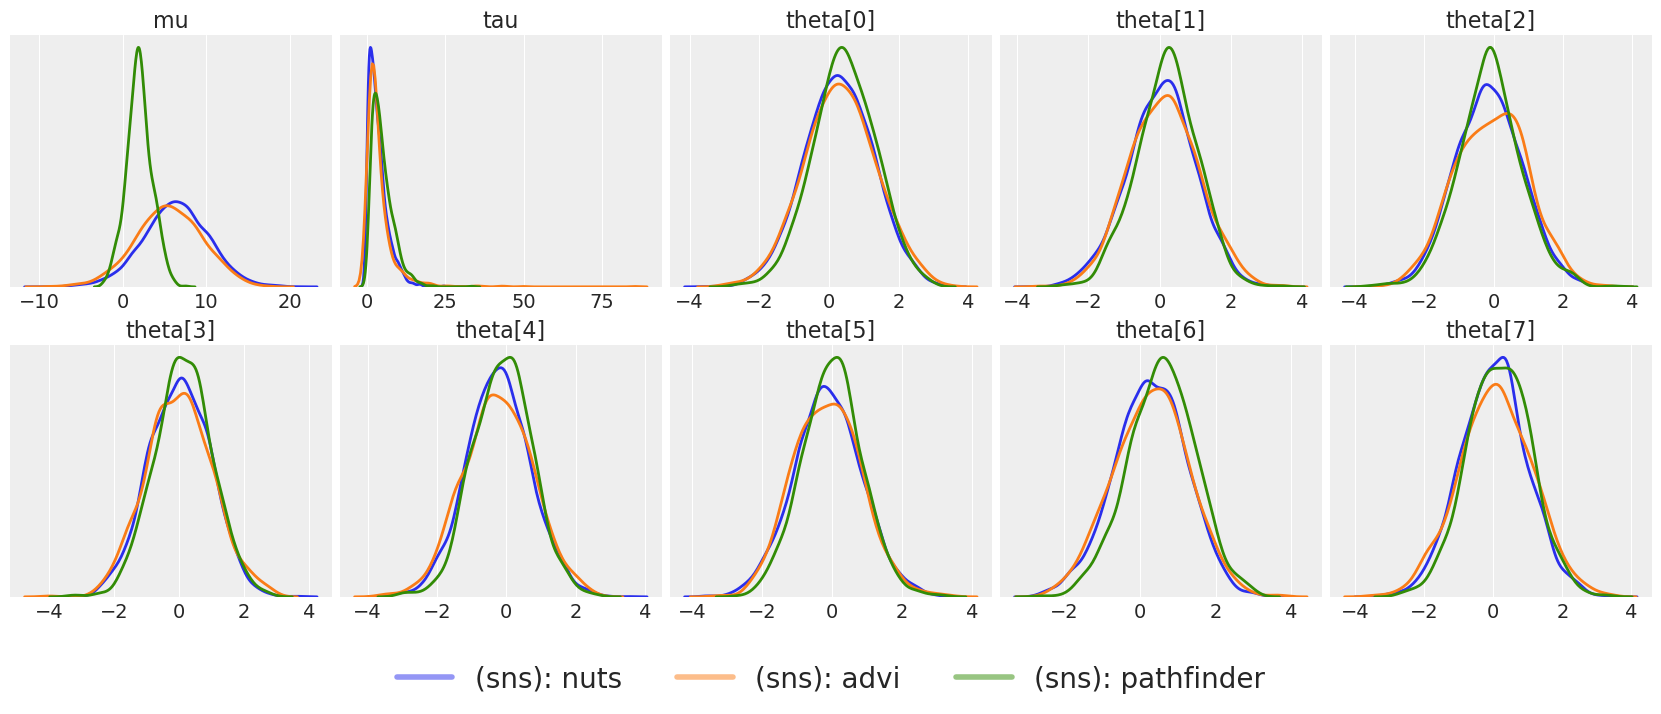

In [6]:
res = {"nuts": idata_nuts, "advi": idata_advi, "pathfinder": idata_pf}
plot_results(res, fill=False, linewidth=2, alpha=1)

In [7]:
with model:
    idata_jitter_pf = pmx.fit(
        method="pathfinder",
        jitter=10.0,
        random_seed=41,
    )

    idata_jitter_paths_pf = pmx.fit(
        method="pathfinder",
        num_paths=50,
        jitter=10.0,
        random_seed=41,
    )

Output()

Pathfinder Results                          
                                            
  No. model parameters     10               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    7                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   10.0             
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 25 ± std 8  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 10 ± std 8  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.91             
                                            
  Timing (seconds):                         
  Compile                  4.28             
  Compute                  0.15             
  Total                    4.42

Output()

Pathfinder Results                           
                                             
  No. model parameters     10                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    7                 
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   10.0              
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                50                
  L-BFGS iterations        mean 27 ± std 11  
                                             
  Path Status:                               
  SUCCESS                  49                
  ELBO_ARGMAX_AT_ZERO      1                 
  ELBO argmax              mean 11 ± std 10  
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 0.77              
                                             
  Timing (seconds):                          
  Compile                  2.63              
  Compute                  1.77              
  Total                    4.40              

Warnings:
  - ELBO argmax at zero refers to the first iteration during LBFGS. A high occurrence suggests the model's         
  default initial point + jitter values are concentrated in high-density regions in the target distribution and    
  may result in poor exploration of the parameter space. Consider increasing jitter if this occurrence is high     
  relative to the number of paths.

The small mu value (approx 1.5) for pathfinder with the default jitter of 2.0 is consistent with the results of Stan's multipath Pathfinder fit.

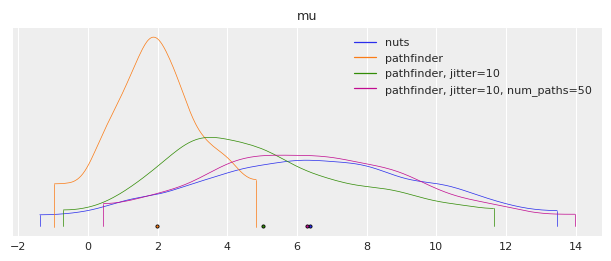

In [8]:
az.plot_density(
    [idata_nuts, idata_pf, idata_jitter_pf, idata_jitter_paths_pf],
    data_labels=[
        "nuts",
        "pathfinder",
        "pathfinder, jitter=10",
        "pathfinder, jitter=10, num_paths=50",
    ],
    var_names=["mu"],
    figsize=(6, 2.5),
    textsize=8,
);

In [9]:
az.summary(idata_jitter_paths_pf)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,6.285,3.522,0.434,13.996,0.116,0.082,927.0,952.0,NaN
tau,2.702,2.630,0.023,7.332,0.088,0.062,886.0,1069.0,NaN
theta[0],0.221,1.004,-1.881,1.970,0.033,0.023,917.0,983.0,NaN
theta[1],0.030,0.982,-1.759,1.924,0.032,0.023,962.0,838.0,NaN
theta[2],-0.109,1.021,-2.265,1.581,0.033,0.024,935.0,883.0,NaN
theta[3],0.019,0.977,-1.776,1.848,0.031,0.023,1012.0,980.0,NaN
theta[4],-0.154,0.947,-2.142,1.505,0.035,0.025,756.0,773.0,NaN
theta[5],-0.122,0.949,-1.807,1.761,0.029,0.020,1103.0,981.0,NaN
theta[6],0.209,0.984,-1.652,2.052,0.030,0.023,1051.0,942.0,NaN
theta[7],0.055,0.984,-1.855,1.792,0.033,0.024,872.0,798.0,NaN


In [11]:
with model:
    idata_no_importance_sampling = pmx.fit(
        method="pathfinder",
        num_paths=50,
        random_seed=41,
        importance_sampling=None,
    )

Output()

Pathfinder Results                          
                                            
  No. model parameters     10               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    7                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                50               
  L-BFGS iterations        mean 18 ± std 5  
                                            
  Path Status:                              
  SUCCESS                  38               
  ELBO_ARGMAX_AT_ZERO      12               
  ELBO argmax              mean 4 ± std 5   
                                            
  Importance Sampling:                      
  Method                                    
                                            
  Timing (seconds):                         
  Compile                  4.70             
  Compute                  1.37             
  Total                    6.07             

Warnings:
  - ELBO argmax at zero refers to the first iteration during LBFGS. A high occurrence suggests the model's         
  default initial point + jitter values are concentrated in high-density regions in the target distribution and    
  may result in poor exploration of the parameter space. Consider increasing jitter if this occurrence is high     
  relative to the number of paths.                                                                                 
  - Importance sampling is disabled. The samples are returned as is which may include samples from failed paths    
  with non-finite logP or logQ values. It is recommended to use importance_sampling='psis' for better              
  stability.

Without importance sampling, and although it is not recommended, it is now possible to compute r_hat. r_hat should not be a diagnostic measure for a model fitted with Pathfinder as each path can, and is expected to, exploit different regions of the posterior. So the between path (or chain) variance is expected to be large. The region in which a path exploits may be sensitive to the jitter scale used to randomise the initialisation of the path.

It is, therefore, recommended to use importance sampling because it is possible for a path or subset of paths to exploit a region of the posterior that can be far away from the posterior mean. Importance sampling assigns importance weights to each sample to make new random draws, and so reduces the variance of the collective samples from all paths and the resulting samples are likely to reflect the true posterior.

In [12]:
az.summary(idata_no_importance_sampling)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.424,2.982,-2.776,6.387,0.197,0.162,137.0,118.0,1.27
tau,11.839,21.777,0.185,34.393,1.448,1.025,128.0,280.0,1.29
theta[0],0.529,0.881,-1.160,2.174,0.031,0.022,801.0,2447.0,1.04
theta[1],0.259,0.839,-1.364,1.885,0.013,0.019,3982.0,3872.0,1.04
theta[2],-0.075,0.865,-1.717,1.582,0.018,0.015,2344.0,6565.0,1.02
theta[3],0.186,0.844,-1.441,1.794,0.012,0.017,5016.0,3967.0,1.04
theta[4],-0.073,0.830,-1.644,1.560,0.013,0.020,3992.0,3866.0,1.05
theta[5],0.006,0.842,-1.582,1.642,0.009,0.018,8967.0,4789.0,1.03
theta[6],0.609,0.842,-1.046,2.202,0.026,0.018,1033.0,1889.0,1.05
theta[7],0.176,0.856,-1.515,1.768,0.012,0.016,5234.0,7611.0,1.03


## Rugby example - Hierarchical Poisson Regression

https://www.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html

In [13]:
try:
    df_all = pd.read_csv("../data/rugby.csv", index_col=0)
except:
    df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

In [14]:
plt.rcParams["figure.constrained_layout.use"] = True
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)
coords = {"team": teams}

In [15]:
with pm.Model(coords=coords) as model:
    # constant data
    home_team = pm.Data("home_team", home_idx, dims="match")
    away_team = pm.Data("away_team", away_idx, dims="match")

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=1)
    sd_att = pm.HalfNormal("sd_att", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic("atts", atts_star - pt.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - pt.mean(defs_star), dims="team")
    home_theta = pt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = pt.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims=("match"),
    )

In [16]:
with model:
    print("Starting NUTS fit...")
    %timeit pm.sample(1000, tune=1500, cores=4, progressbar=False)
    print("\nStarting ADVI fit...")
    %timeit pm.fit(n=30_000, progressbar=False).sample(1000)
    print("\nStarting Pathfinder fit...")
    %timeit pmx.fit(method="pathfinder")

Starting NUTS fit...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 6 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 7 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 8 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 7 seconds.
Initializing NUTS using jitter+ad

9.02 s ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Starting ADVI fit...


Finished [100%]: Average Loss = 557.51
Finished [100%]: Average Loss = 557.53
Finished [100%]: Average Loss = 557.56
Finished [100%]: Average Loss = 557.52
Finished [100%]: Average Loss = 557.57
Finished [100%]: Average Loss = 557.52
Finished [100%]: Average Loss = 557.53
Finished [100%]: Average Loss = 557.51


5.61 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Starting Pathfinder fit...


Output()

Pathfinder Results                          
                                            
  No. model parameters     16               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    9                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 34 ± std 2  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 24 ± std 6  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.92             
                                            
  Timing (seconds):                         
  Compile                  5.53             
  Compute                  0.39             
  Total                    5.92

Output()

Pathfinder Results                          
                                            
  No. model parameters     16               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    9                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 34 ± std 4  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 23 ± std 3  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.86             
                                            
  Timing (seconds):                         
  Compile                  4.41             
  Compute                  0.33             
  Total                    4.74

Output()

Pathfinder Results                          
                                            
  No. model parameters     16               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    9                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 34 ± std 3  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 26 ± std 5  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.95             
                                            
  Timing (seconds):                         
  Compile                  6.56             
  Compute                  0.30             
  Total                    6.86

Output()

Pathfinder Results                          
                                            
  No. model parameters     16               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    9                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 37 ± std 7  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 24 ± std 4  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 1.15             
                                            
  Timing (seconds):                         
  Compile                  4.68             
  Compute                  0.41             
  Total                    5.08

Output()

Pathfinder Results                          
                                            
  No. model parameters     16               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    9                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 37 ± std 5  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 25 ± std 1  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.77             
                                            
  Timing (seconds):                         
  Compile                  4.47             
  Compute                  0.38             
  Total                    4.85

Output()

Pathfinder Results                          
                                            
  No. model parameters     16               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    9                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 38 ± std 7  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 27 ± std 9  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.83             
                                            
  Timing (seconds):                         
  Compile                  3.03             
  Compute                  0.34             
  Total                    3.37

Output()

Pathfinder Results                          
                                            
  No. model parameters     16               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    9                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 35 ± std 3  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 28 ± std 6  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 1.13             
                                            
  Timing (seconds):                         
  Compile                  4.73             
  Compute                  0.37             
  Total                    5.10

Output()

Pathfinder Results                          
                                            
  No. model parameters     16               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    9                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 35 ± std 4  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 25 ± std 6  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.83             
                                            
  Timing (seconds):                         
  Compile                  4.50             
  Compute                  0.34             
  Total                    4.84

5.36 s ± 692 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
with model:
    idata_nuts = pm.sample(1000, tune=1500, cores=4, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_pf = pmx.fit(method="pathfinder")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 8 seconds.
Finished [100%]: Average Loss = 557.47


Output()

Pathfinder Results                           
                                             
  No. model parameters     16                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    9                 
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   2.0               
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                4                 
  L-BFGS iterations        mean 40 ± std 12  
                                             
  Path Status:                               
  SUCCESS                  4                 
  ELBO argmax              mean 24 ± std 7   
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 0.95              
                                             
  Timing (seconds):                          
  Compile                  3.20              
  Compute                  0.43              
  Total                    3.63

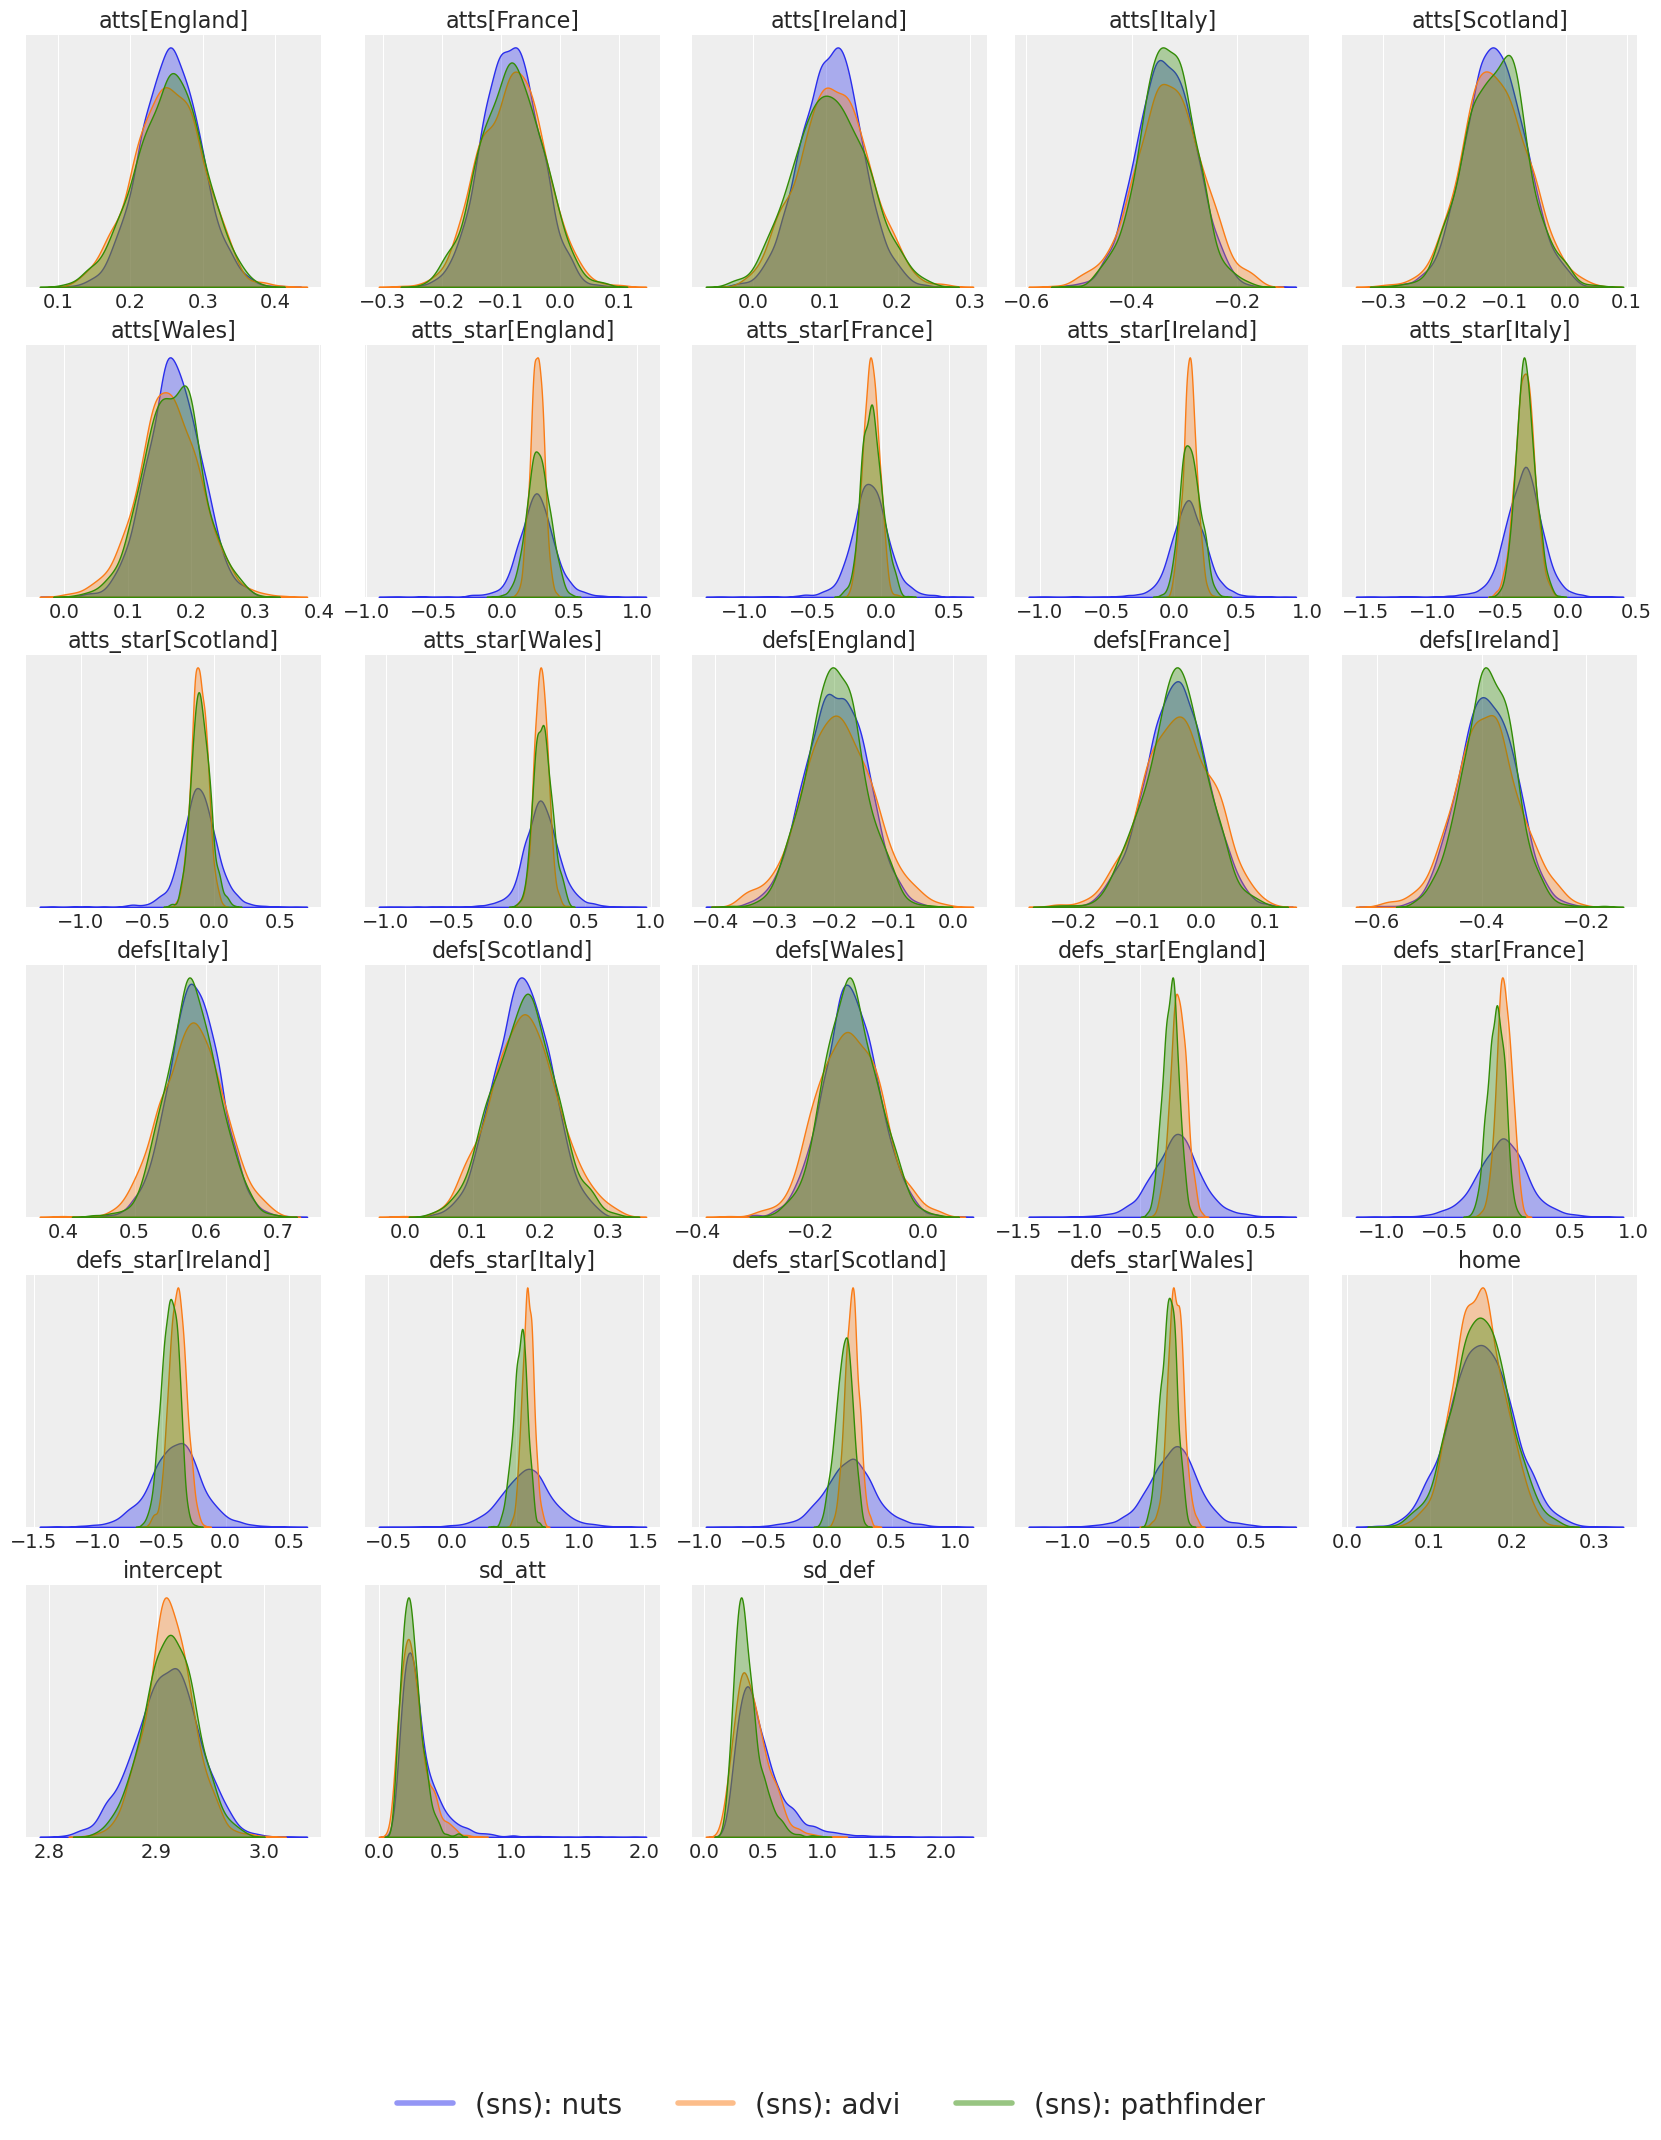

In [18]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
}
plot_results(res)

## Cherry Blossoms - Spline Regression

In [19]:
from patsy import dmatrix
from pathlib import Path

RANDOM_SEED = 8927

In [20]:
try:
    blossom_data = pd.read_csv(Path("..", "data", "cherry_blossoms.csv"), sep=";")
except FileNotFoundError:
    blossom_data = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")


blossom_data = blossom_data.dropna(subset=["doy"]).reset_index(drop=True)

In [21]:
num_knots = 15
knot_list = np.quantile(blossom_data.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

In [22]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": blossom_data.year.values, "knots": knot_list[1:-1]},
)

In [23]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

In [24]:
COORDS = {"splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS) as spline_model:
    a = pm.Normal("a", 100, 5)
    w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=blossom_data.doy)

In [26]:
with spline_model:
    idata_nuts = pm.sample(1000, tune=1000, cores=4, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_pf = pmx.fit(method="pathfinder")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Finished [100%]: Average Loss = 2,681.9


Output()

Pathfinder Results                          
                                            
  No. model parameters     19               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    9                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 32 ± std 8  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 27 ± std 7  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 1.00             
                                            
  Timing (seconds):                         
  Compile                  8.86             
  Compute                  0.29             
  Total                    9.15

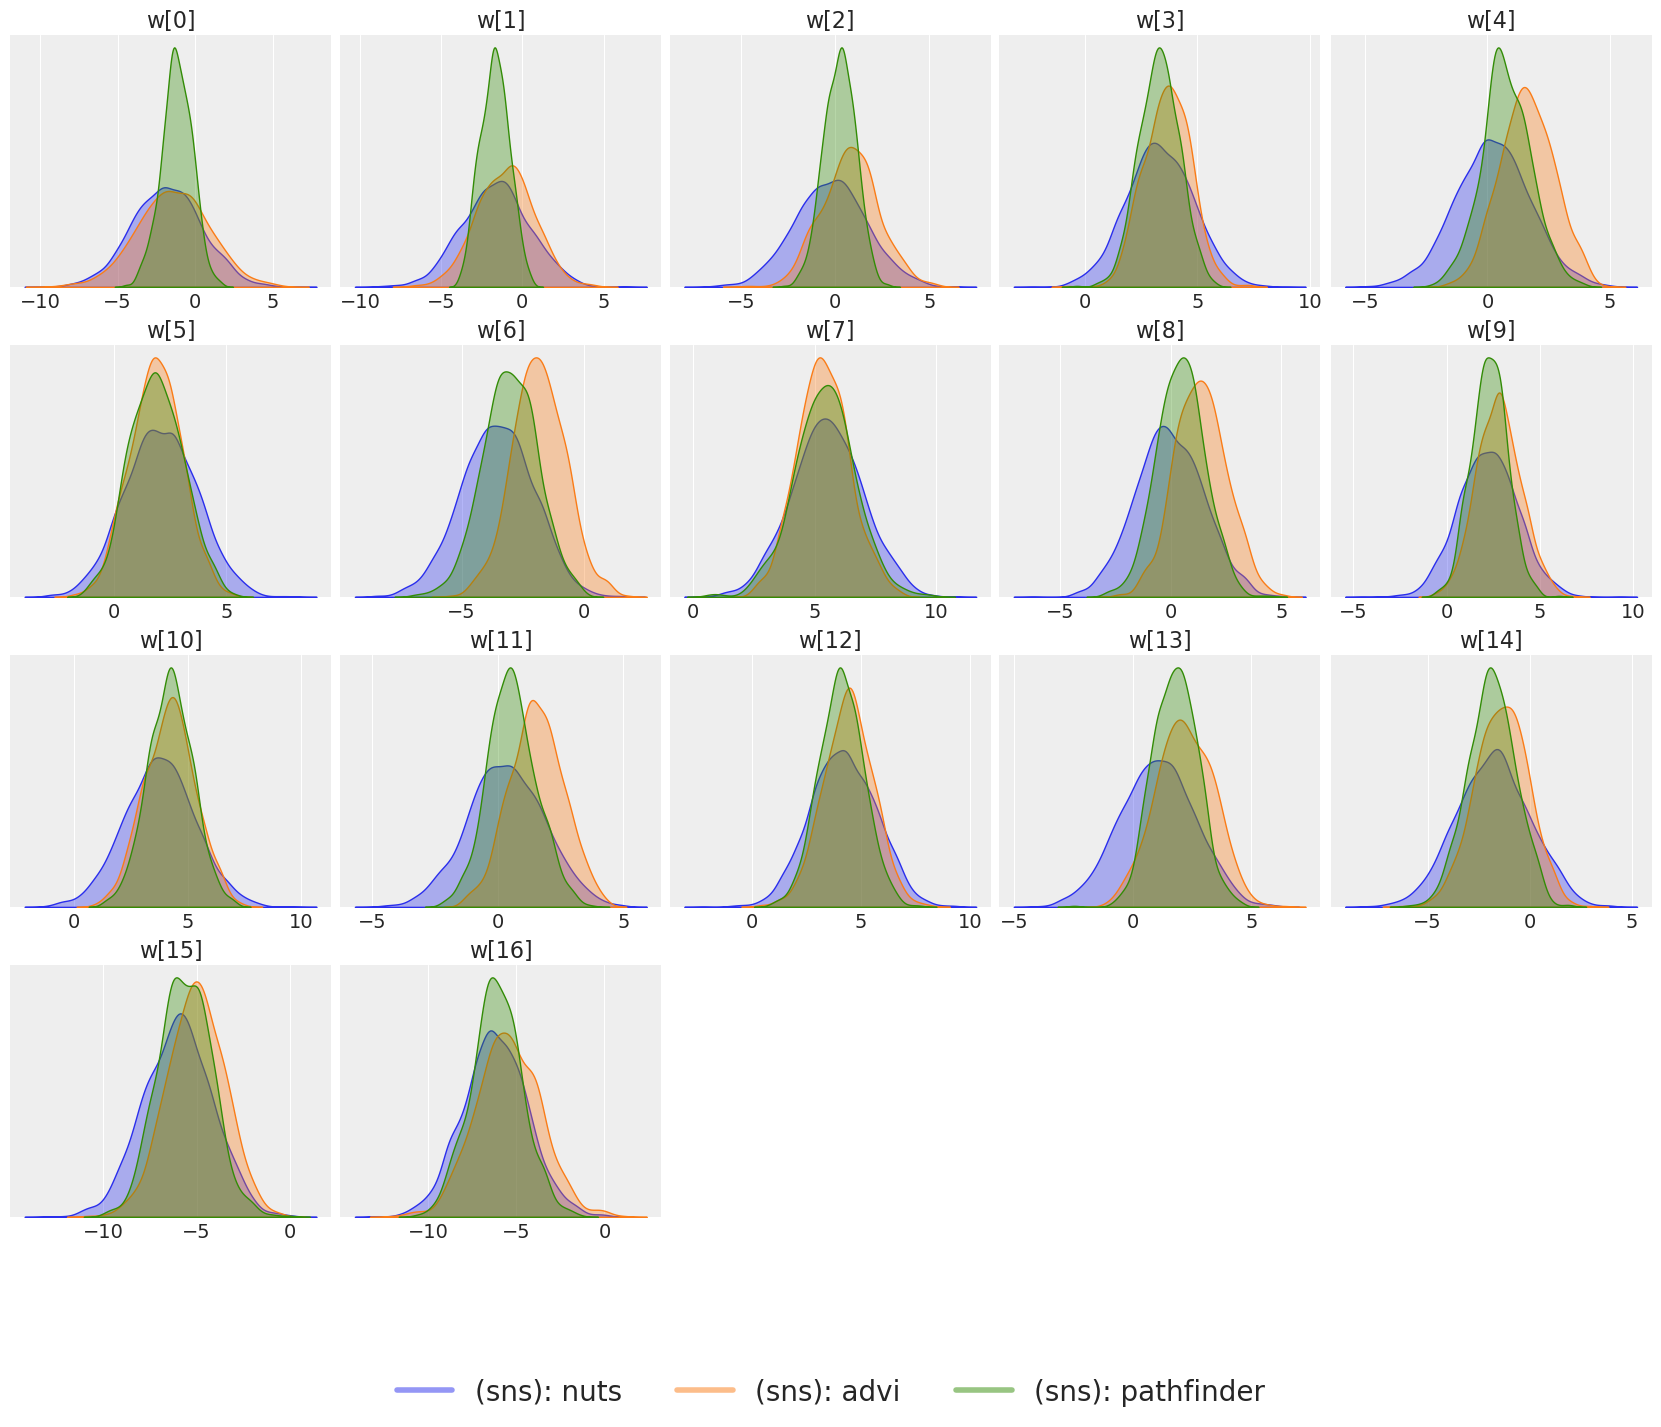

In [27]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
}
plot_results(res, var_names=["w"])

Pathfinder appears to underestimate the variance for some of the spline weights. Not to worry, we can increase the jitter and number of paths to help with this.

In [28]:
with spline_model:
    idata_jitter_pf = pmx.fit(method="pathfinder", jitter=20.0, random_seed=41)
    idata_jitter_paths_pf = pmx.fit(
        method="pathfinder", jitter=20.0, num_paths=50, random_seed=41
    )
    idata_jitter_paths_maxcor_pf = pmx.fit(
        method="pathfinder", maxcor=25, jitter=20.0, num_paths=50, random_seed=41
    )

Output()

Pathfinder Results                          
                                            
  No. model parameters     19               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    9                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   20.0             
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 67 ± std 7  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 62 ± std 4  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.91             
                                            
  Timing (seconds):                         
  Compile                  2.90             
  Compute                  0.30             
  Total                    3.20

Output()

Pathfinder Results                           
                                             
  No. model parameters     19                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    9                 
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   20.0              
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                50                
  L-BFGS iterations        mean 66 ± std 21  
                                             
  Path Status:                               
  SUCCESS                  50                
  ELBO argmax              mean 61 ± std 20  
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 0.99              
                                             
  Timing (seconds):                          
  Compile                  4.44              
  Compute                  4.27              
  Total                    8.71

Output()

Pathfinder Results                           
                                             
  No. model parameters     19                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    25                
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   20.0              
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                50                
  L-BFGS iterations        mean 63 ± std 21  
                                             
  Path Status:                               
  SUCCESS                  50                
  ELBO argmax              mean 55 ± std 21  
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 1.04              
                                             
  Timing (seconds):                          
  Compile                  4.73              
  Compute                  26.21             
  Total                    30.94

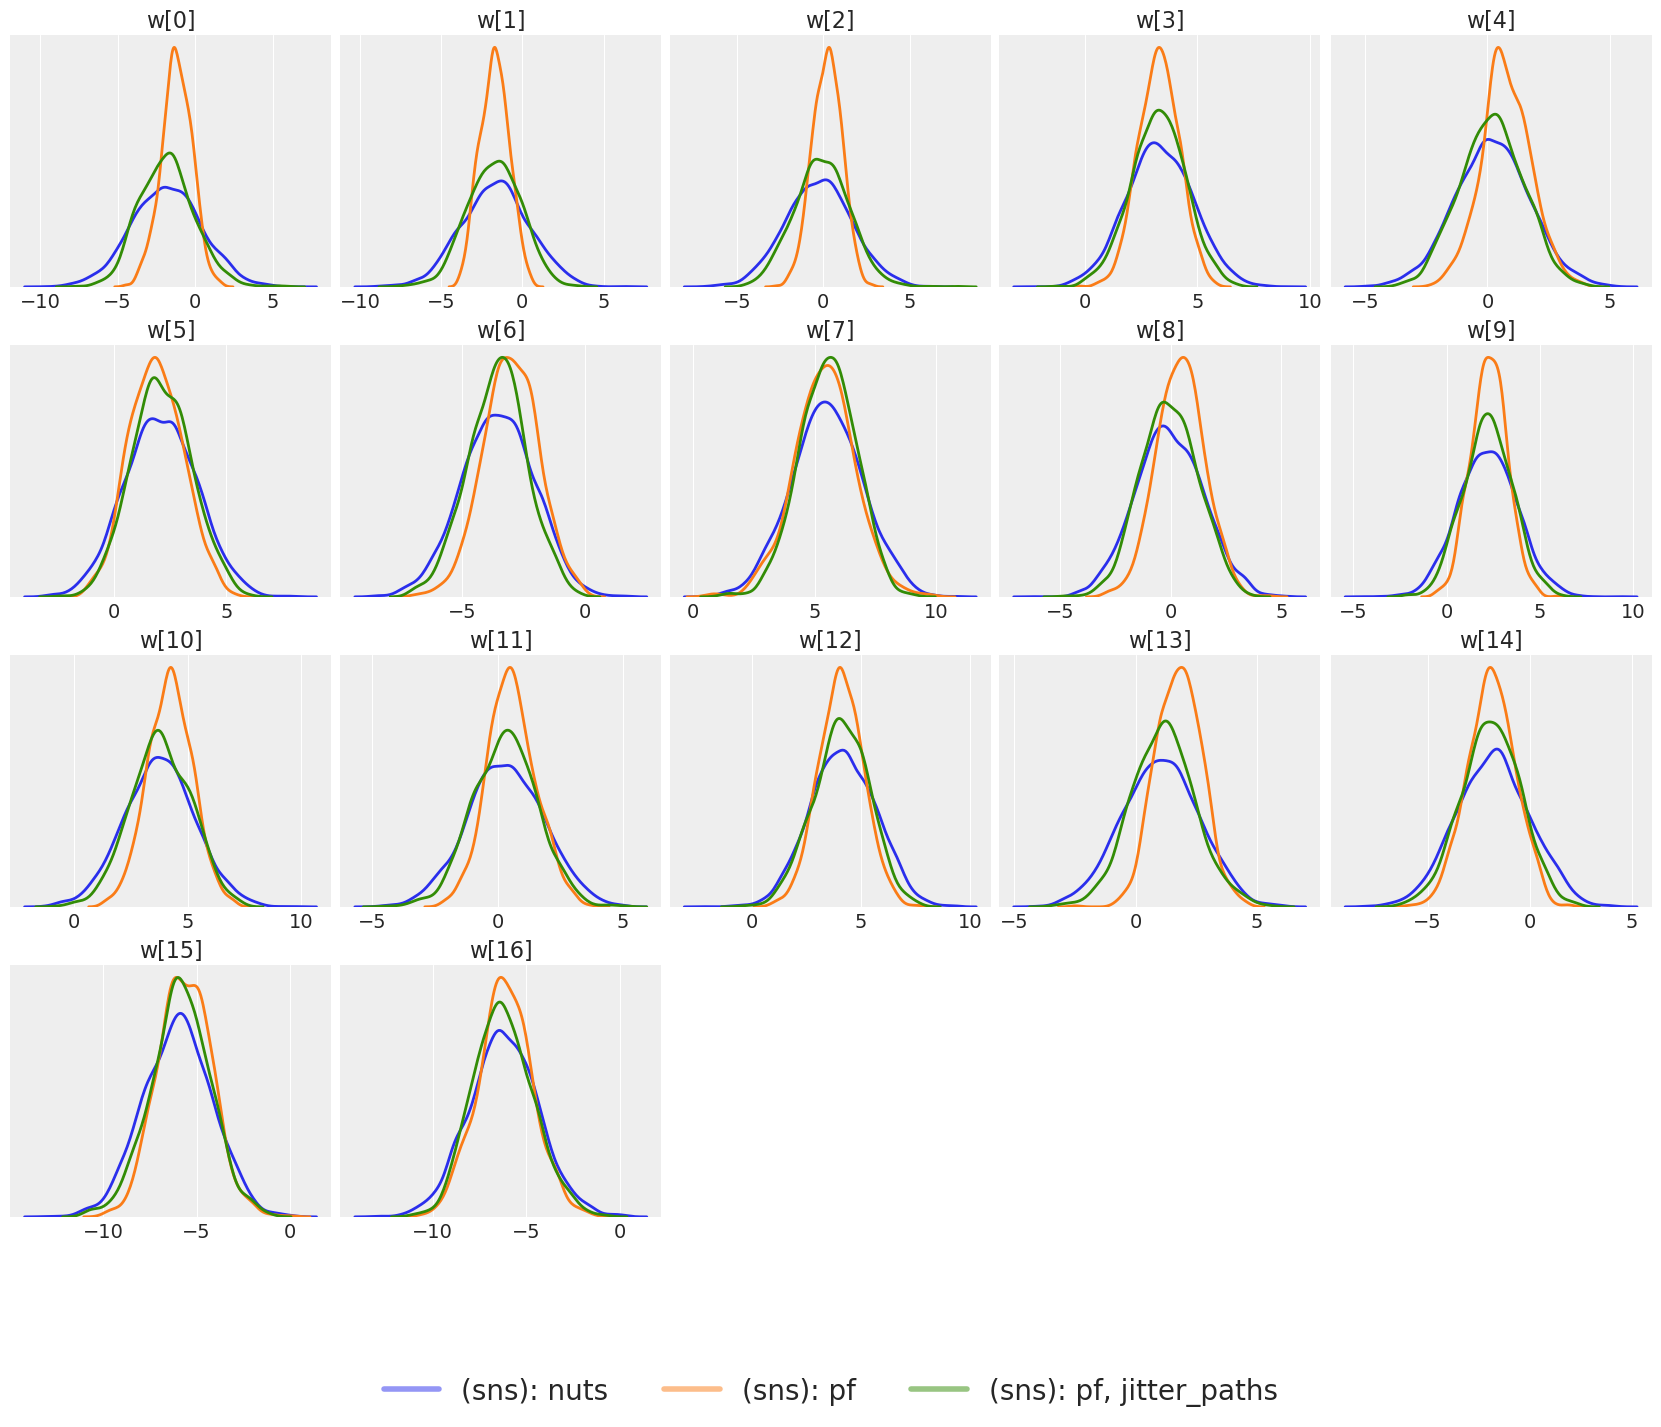

In [29]:
res = {
    "nuts": idata_nuts,
    "pf": idata_pf,
    # "pf, jitter": idata_jitter_pf,
    "pf, jitter_paths": idata_jitter_paths_pf,
    # "pf, jitter_paths_maxcor": idata_jitter_paths_maxcor_pf,
}
plot_results(res, var_names=["w"], fill=False, linewidth=2, alpha=1)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

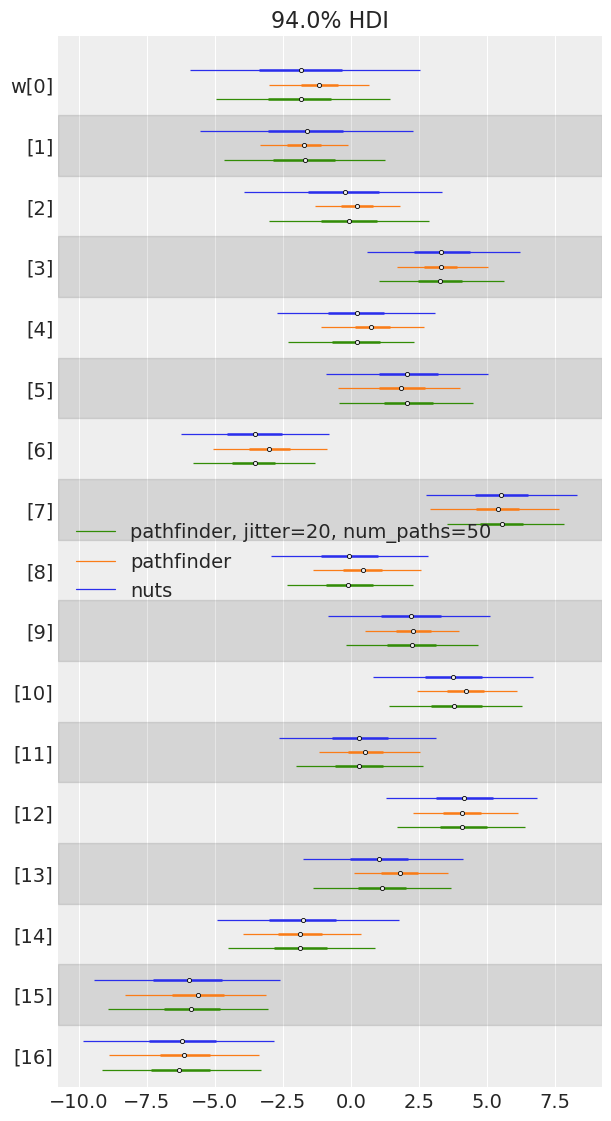

In [30]:
az.plot_forest(
    [idata_nuts, idata_pf, idata_jitter_paths_pf],
    model_names=["nuts", "pathfinder", "pathfinder, jitter=20, num_paths=50"],
    var_names=["w"],
    combined=True,
)

## Truncated and Censored Regression example

In [31]:
rng = default_rng(12345)
slope, intercept, sigma, N = 1, 0, 2, 200
x = rng.uniform(-10, 10, N)
y = rng.normal(loc=slope * x + intercept, scale=sigma)


def truncate_y(x, y, bounds):
    keep = (y >= bounds[0]) & (y <= bounds[1])
    return (x[keep], y[keep])


def censor_y(x, y, bounds):
    cy = copy(y)
    cy[y <= bounds[0]] = bounds[0]
    cy[y >= bounds[1]] = bounds[1]
    return (x, cy)

In [32]:
bounds = [-5, 5]
xt, yt = truncate_y(x, y, bounds)
xc, yc = censor_y(x, y, bounds)

In [33]:
def linear_regression(x, y):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        sigma = pm.HalfNormal("σ", sigma=1)
        pm.Normal("obs", mu=slope * x + intercept, sigma=sigma, observed=y)

    return model


trunc_linear_model = linear_regression(xt, yt)

In [34]:
with trunc_linear_model:
    idata_nuts = pm.sample(1000, tune=1500, cores=4, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_pf = pmx.fit(method="pathfinder")

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took -0 seconds.
Finished [100%]: Average Loss = 198.53


Output()

Pathfinder Results                          
                                            
  No. model parameters     3                
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    5                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 12 ± std 2  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 7 ± std 2   
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.45             
                                            
  Timing (seconds):                         
  Compile                  5.03             
  Compute                  0.17             
  Total                    5.19

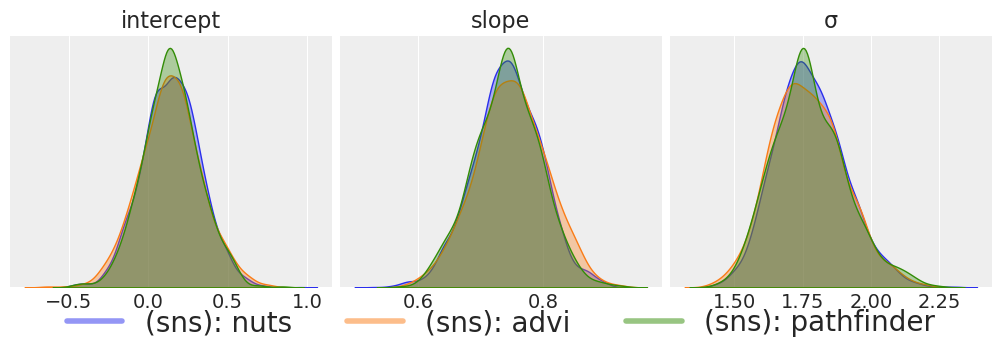

In [35]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
}
plot_results(res)

## Radon household example - Hierarchical Linear Regression

In [36]:
try:
    data = pd.read_csv(os.path.join("..", "data", "radon.csv"))
except FileNotFoundError:
    data = pd.read_csv(pm.get_data("radon.csv"))

In [37]:
county_idx = data["county_code"].values
floor_idx = data["floor"].values
log_radon_idx = data["log_radon"].values

coords = {"counties": data.county.unique()}

In [38]:
with pm.Model(coords=coords) as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_alpha", mu=0.0, sigma=100**2)
    sigma_a = pm.Uniform("sigma_alpha", lower=0, upper=100)
    mu_b = pm.Normal("mu_beta", mu=0.0, sigma=100**2)
    sigma_b = pm.Uniform("sigma_beta", lower=0, upper=100)

    a = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="counties")
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="counties")

    radon_est = a[county_idx] + b[county_idx] * floor_idx

    # Model error
    eps = pm.Uniform("eps", lower=0, upper=100)

    # Data likelihood
    radon_like = pm.Normal(
        "radon_like",
        mu=radon_est,
        sigma=eps,
        observed=log_radon_idx,
    )

In [39]:
log_radon_idx_t = pm.Minibatch(log_radon_idx, batch_size=100)
floor_idx_t = pm.Minibatch(floor_idx, batch_size=100)
county_idx_t = pm.Minibatch(county_idx, batch_size=100)

In [40]:
with pm.Model(coords=coords) as mb_hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_alpha", mu=0.0, sigma=100**2)
    sigma_a = pm.Uniform("sigma_alpha", lower=0, upper=100)
    mu_b = pm.Normal("mu_beta", mu=0.0, sigma=100**2)
    sigma_b = pm.Uniform("sigma_beta", lower=0, upper=100)

    a = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="counties")
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="counties")

    radon_est = a[county_idx_t] + b[county_idx_t] * floor_idx_t

    # Model error
    eps = pm.Uniform("eps", lower=0, upper=100)

    # Data likelihood
    radon_like = pm.Normal(
        "radon_like",
        mu=radon_est,
        sigma=eps,
        observed=log_radon_idx_t,
        total_size=len(data),
    )

In [41]:
with hierarchical_model:
    idata_nuts = pm.sample(1000, tune=1500, cores=4, progressbar=False)

with mb_hierarchical_model:
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)

with hierarchical_model:
    idata_psir_pf = pmx.fit(
        method="pathfinder", importance_sampling="psir", random_seed=412
    )
    idata_pf = pmx.fit(method="pathfinder", random_seed=412)

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha, beta, eps]
Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 7 seconds.
There were 989 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Finished [100%]: Average Loss = 152.21


Output()

Pathfinder Results                            
                                              
  No. model parameters     175                
                                              
  Configuration:                              
  num_draws_per_path       1000               
  history size (maxcor)    16                 
  max iterations           1000               
  ftol                     1.00e-05           
  gtol                     1.00e-08           
  max line search          1000               
  jitter                   2.0                
  epsilon                  1.00e-08           
  ELBO draws               10                 
                                              
  LBFGS Status:                               
  CONVERGED                4                  
  L-BFGS iterations        mean 263 ± std 93  
                                              
  Path Status:                                
  SUCCESS                  4                  
  ELBO argmax              mean 32 ± std 2    
                                              
  Importance Sampling:                        
  Method                   psir               
  Pareto k                 3.60               
                                              
  Timing (seconds):                           
  Compile                  9.06               
  Compute                  3.51               
  Total                    12.56

Output()

Pathfinder Results                            
                                              
  No. model parameters     175                
                                              
  Configuration:                              
  num_draws_per_path       1000               
  history size (maxcor)    16                 
  max iterations           1000               
  ftol                     1.00e-05           
  gtol                     1.00e-08           
  max line search          1000               
  jitter                   2.0                
  epsilon                  1.00e-08           
  ELBO draws               10                 
                                              
  LBFGS Status:                               
  CONVERGED                4                  
  L-BFGS iterations        mean 263 ± std 93  
                                              
  Path Status:                                
  SUCCESS                  4                  
  ELBO argmax              mean 32 ± std 2    
                                              
  Importance Sampling:                        
  Method                   psis               
  Pareto k                 3.60               
                                              
  Timing (seconds):                           
  Compile                  5.51               
  Compute                  1.48               
  Total                    6.99

This was the point when I realised that the PSIR importance sampling was problematic! So I have made the default importance sampling to PSIS.

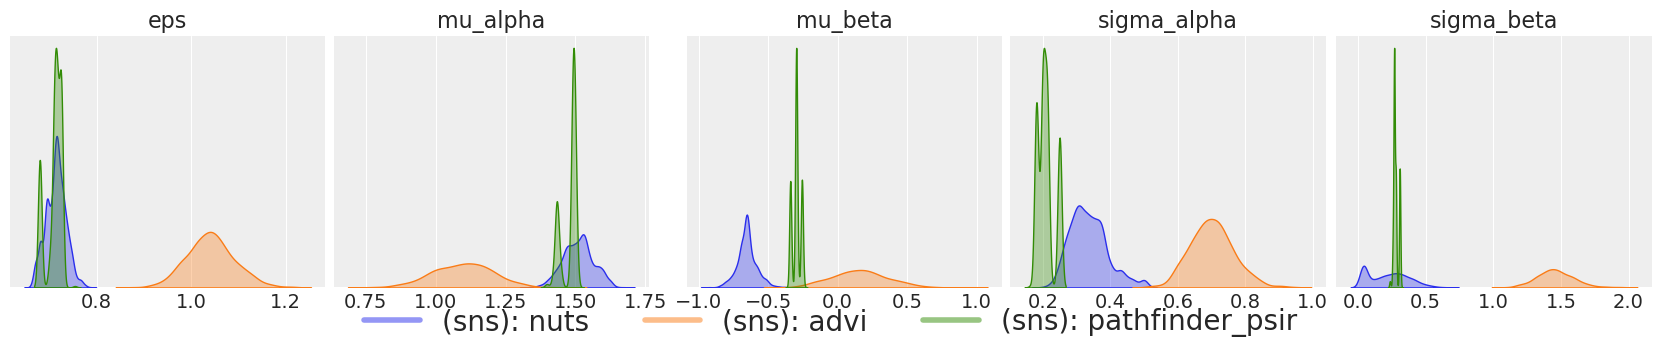

In [42]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    # "pathfinder": idata_pf,
    "pathfinder_psir": idata_psir_pf,
}
plot_results(res, var_names=["~alpha", "~beta"])

Compared to PSIS, you don't get the extreme peaks like PSIR does.

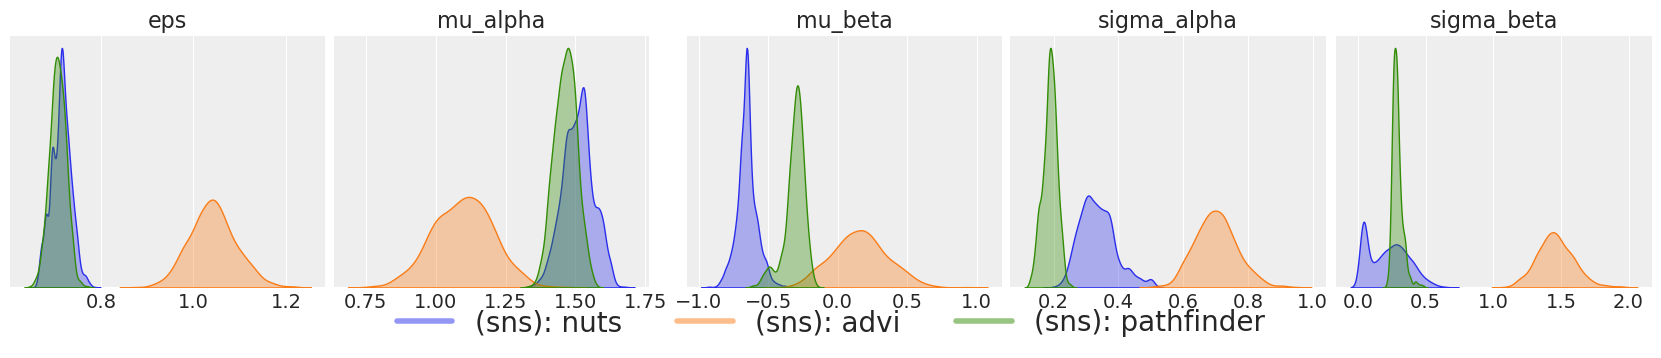

In [43]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
    # "pathfinder_psir": idata_psir_pf,
}
plot_results(res, var_names=["~alpha", "~beta"])

Output()

Pathfinder Results                            
                                              
  No. model parameters     175                
                                              
  Configuration:                              
  num_draws_per_path       1000               
  history size (maxcor)    16                 
  max iterations           1000               
  ftol                     1.00e-05           
  gtol                     1.00e-08           
  max line search          1000               
  jitter                   20.0               
  epsilon                  1.00e-08           
  ELBO draws               10                 
                                              
  LBFGS Status:                               
  CONVERGED                50                 
  L-BFGS iterations        mean 262 ± std 82  
                                              
  Path Status:                                
  SUCCESS                  48                 
  ELBO_ARGMAX_AT_ZERO      1                  
  INVALID_LOGP             1                  
  ELBO argmax              mean 113 ± std 38  
                                              
  Importance Sampling:                        
  Method                   psis               
  Pareto k                 5.49               
                                              
  Timing (seconds):                           
  Compile                  5.46               
  Compute                  36.26              
  Total                    41.72              

Warnings:
  - ELBO argmax at zero refers to the first iteration during LBFGS. A high occurrence suggests the model's         
  default initial point + jitter values are concentrated in high-density regions in the target distribution and    
  may result in poor exploration of the parameter space. Consider increasing jitter if this occurrence is high     
  relative to the number of paths.

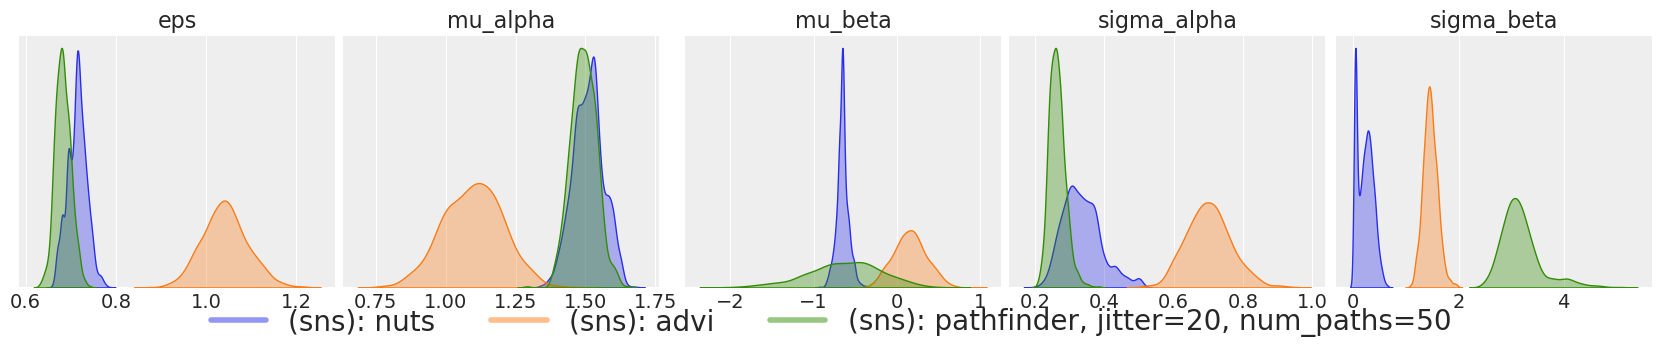

In [44]:
with hierarchical_model:
    idata_jitter_paths_pf = pmx.fit(
        method="pathfinder", jitter=20.0, num_paths=50, random_seed=412
    )
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder, jitter=20, num_paths=50": idata_jitter_paths_pf,
}
plot_results(res, var_names=["~alpha", "~beta"])

Output()

Pathfinder Results                            
                                              
  No. model parameters     175                
                                              
  Configuration:                              
  num_draws_per_path       1000               
  history size (maxcor)    16                 
  max iterations           1000               
  ftol                     1.00e-05           
  gtol                     1.00e-08           
  max line search          1000               
  jitter                   5.0                
  epsilon                  1.00e-08           
  ELBO draws               10                 
                                              
  LBFGS Status:                               
  CONVERGED                50                 
  L-BFGS iterations        mean 184 ± std 27  
                                              
  Path Status:                                
  SUCCESS                  50                 
  ELBO argmax              mean 47 ± std 6    
                                              
  Importance Sampling:                        
  Method                   psis               
  Pareto k                 8.16               
                                              
  Timing (seconds):                           
  Compile                  5.73               
  Compute                  27.42              
  Total                    33.15

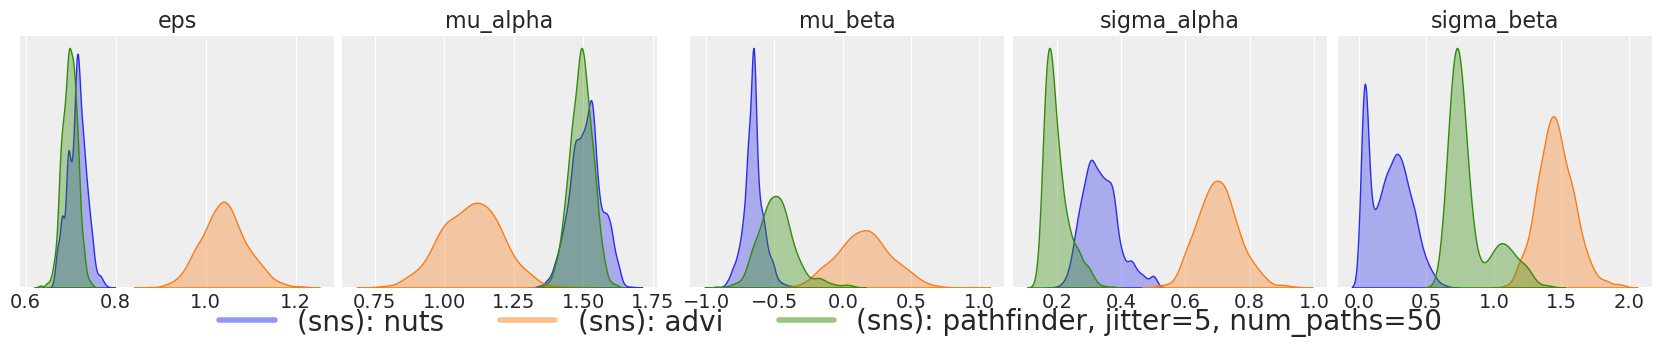

In [45]:
with hierarchical_model:
    idata_jitter_paths_pf2 = pmx.fit(
        method="pathfinder", jitter=5.0, num_paths=50, random_seed=412
    )
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder, jitter=5, num_paths=50": idata_jitter_paths_pf2,
}
plot_results(res, var_names=["~alpha", "~beta"])

Output()

Pathfinder Results                            
                                              
  No. model parameters     175                
                                              
  Configuration:                              
  num_draws_per_path       1000               
  history size (maxcor)    30                 
  max iterations           1000               
  ftol                     1.00e-05           
  gtol                     1.00e-08           
  max line search          1000               
  jitter                   3.5                
  epsilon                  1.00e-08           
  ELBO draws               10                 
                                              
  LBFGS Status:                               
  CONVERGED                50                 
  L-BFGS iterations        mean 174 ± std 38  
                                              
  Path Status:                                
  SUCCESS                  50                 
  ELBO argmax              mean 37 ± std 7    
                                              
  Importance Sampling:                        
  Method                   psis               
  Pareto k                 4.83               
                                              
  Timing (seconds):                           
  Compile                  6.25               
  Compute                  117.11             
  Total                    123.37

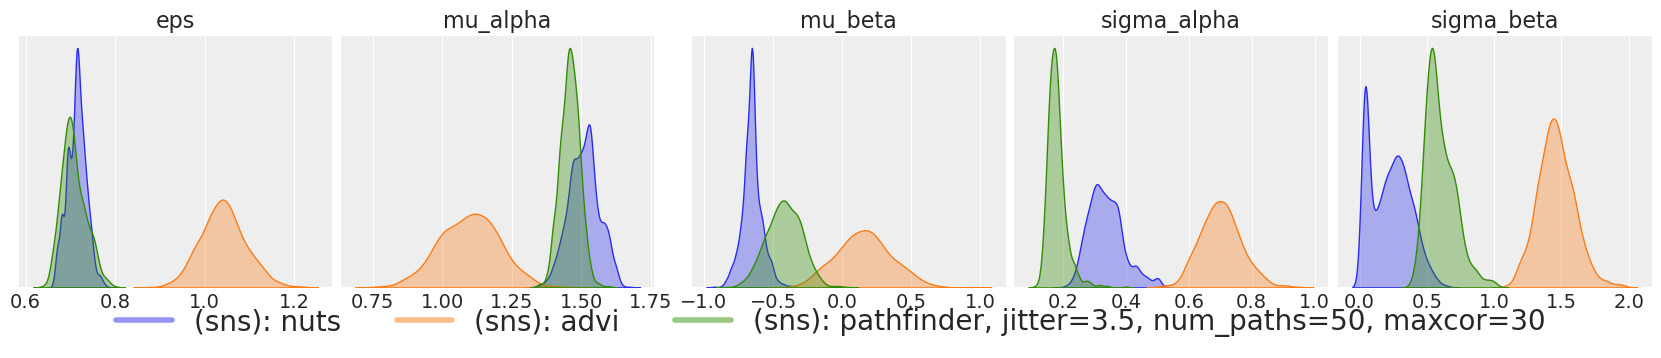

In [46]:
with hierarchical_model:
    idata_jitter_maxcor_paths_pf = pmx.fit(
        method="pathfinder", maxcor=30, jitter=3.5, num_paths=50, random_seed=412
    )
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder, jitter=3.5, num_paths=50, maxcor=30": idata_jitter_maxcor_paths_pf,
}
plot_results(res, var_names=["~alpha", "~beta"])

Setting a high number of paths relative to the parameter space can result in a pointier posterior as you can see in sigma_beta and it gets worse with PSIR.

## Mixture Model example

In [47]:
import scipy

rng = np.random.default_rng(12345)

true_conc = 6.0
true_frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
trees = ["pine", "oak", "ebony", "rosewood", "mahogany"]  # Tree species observed
# fmt: off
forests = [  # Forests observed
    "sunderbans", "amazon", "arashiyama", "trossachs", "valdivian",
    "bosc de poblet", "font groga", "monteverde", "primorye", "daintree",
]
# fmt: on
k = len(trees)
n = len(forests)
total_count = 50

true_p = scipy.stats.dirichlet(true_conc * true_frac).rvs(size=n, random_state=rng)
observed_counts = np.vstack(
    [
        scipy.stats.multinomial(n=total_count, p=p_i).rvs(random_state=rng)
        for p_i in true_p
    ]
)

In [48]:
coords = {"tree": trees, "forest": forests}
with pm.Model(coords=coords) as model_multinomial:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")
    counts = pm.Multinomial(
        "counts",
        n=total_count,
        p=frac,
        observed=observed_counts,
        dims=("forest", "tree"),
    )

In [49]:
with model_multinomial:
    idata_nuts = pm.sample(chains=4, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_pf = pmx.fit(method="pathfinder")

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Finished [100%]: Average Loss = 135.21


Output()

Pathfinder Results                          
                                            
  No. model parameters     4                
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    5                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 12 ± std 1  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 7 ± std 3   
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.73             
                                            
  Timing (seconds):                         
  Compile                  4.48             
  Compute                  0.18             
  Total                    4.66

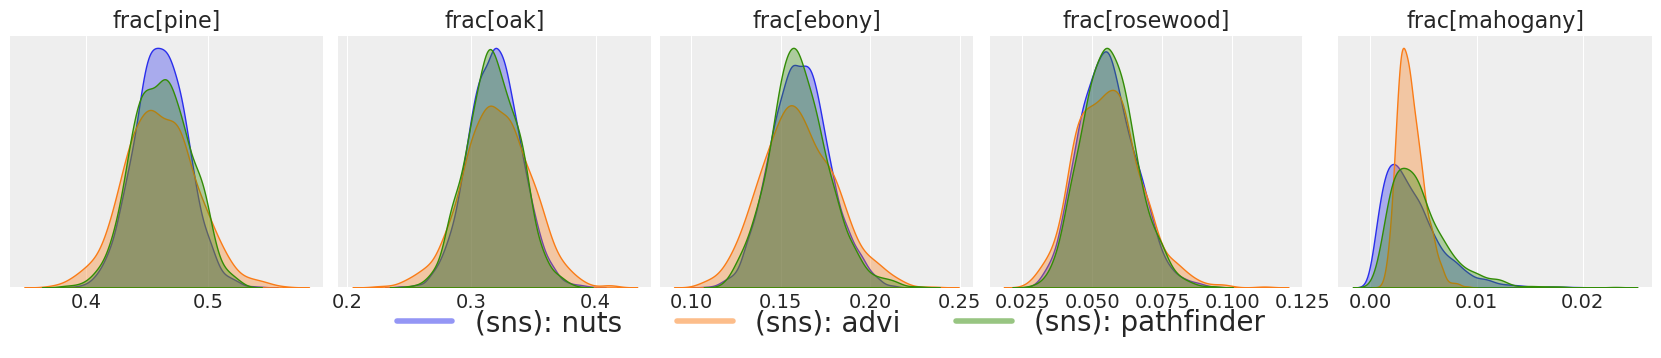

In [50]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder": idata_pf,
}
plot_results(res)

In [51]:
with pm.Model(coords=coords) as model_dm_explicit:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")
    conc = pm.Lognormal("conc", mu=1, sigma=1)
    p = pm.Dirichlet("p", a=frac * conc, dims=("forest", "tree"))
    counts = pm.Multinomial(
        "counts", n=total_count, p=p, observed=observed_counts, dims=("forest", "tree")
    )

In [52]:
with model_dm_explicit:
    idata_nuts = pm.sample(chains=4, target_accept=0.9, progressbar=False)
    idata_advi = pm.fit(n=30_000, progressbar=False).sample(1000)
    idata_psir_pf = pmx.fit(
        method="pathfinder", importance_sampling="psir", random_seed=41
    )
    idata_pf = pmx.fit(method="pathfinder", random_seed=41)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc, p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Finished [100%]: Average Loss = 112.71


Output()

Pathfinder Results                          
                                            
  No. model parameters     45               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    12               
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 28 ± std 2  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 20 ± std 7  
                                            
  Importance Sampling:                      
  Method                   psir             
  Pareto k                 1.15             
                                            
  Timing (seconds):                         
  Compile                  9.25             
  Compute                  0.65             
  Total                    9.91

Output()

Pathfinder Results                          
                                            
  No. model parameters     45               
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    12               
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   2.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                4                
  L-BFGS iterations        mean 28 ± std 2  
                                            
  Path Status:                              
  SUCCESS                  4                
  ELBO argmax              mean 20 ± std 7  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 1.15             
                                            
  Timing (seconds):                         
  Compile                  5.94             
  Compute                  0.64             
  Total                    6.58

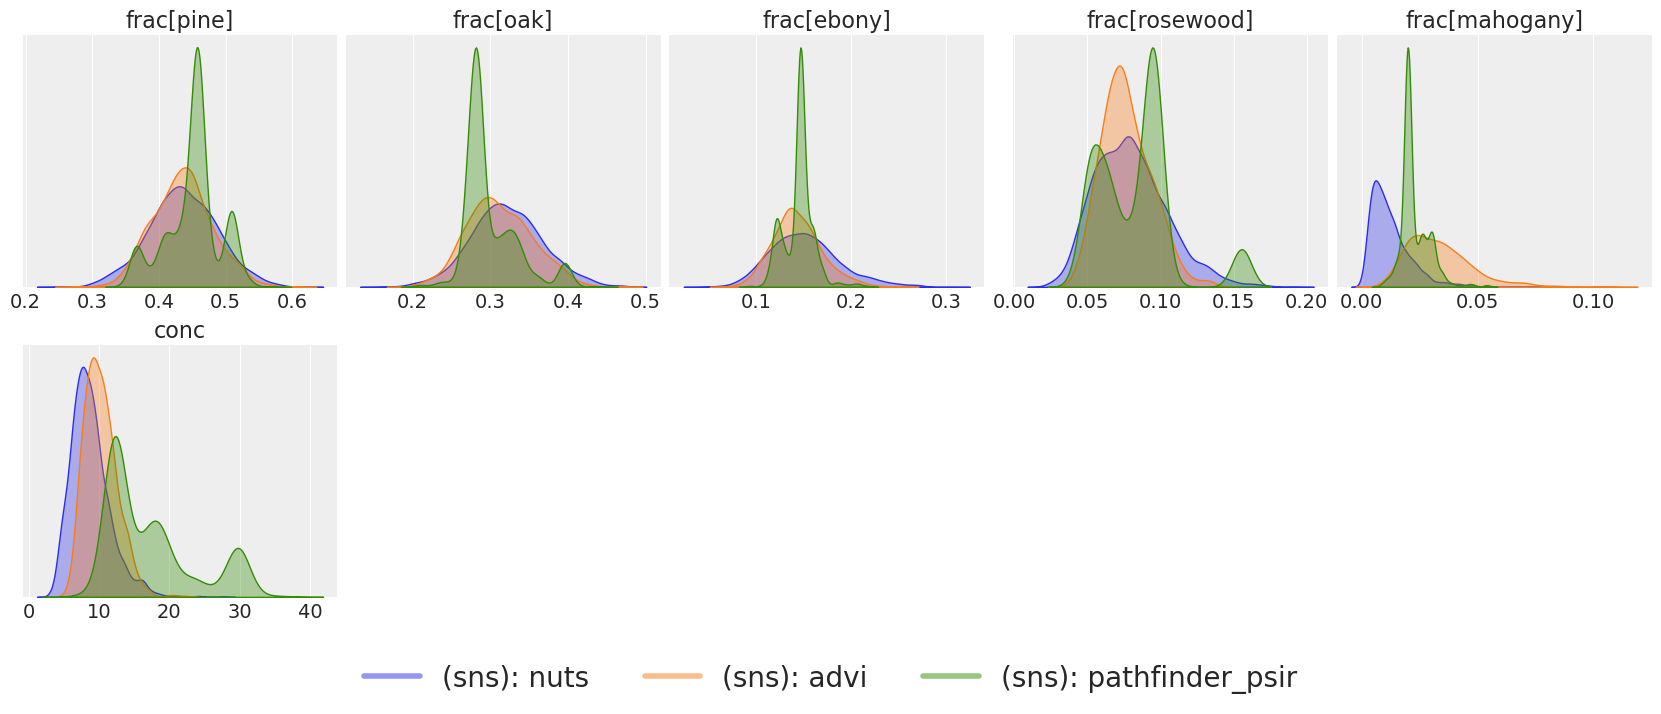

In [53]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    "pathfinder_psir": idata_psir_pf,
    # "pathfinder": idata_pf,
}
plot_results(
    res,
    var_names=["frac", "conc"],
)

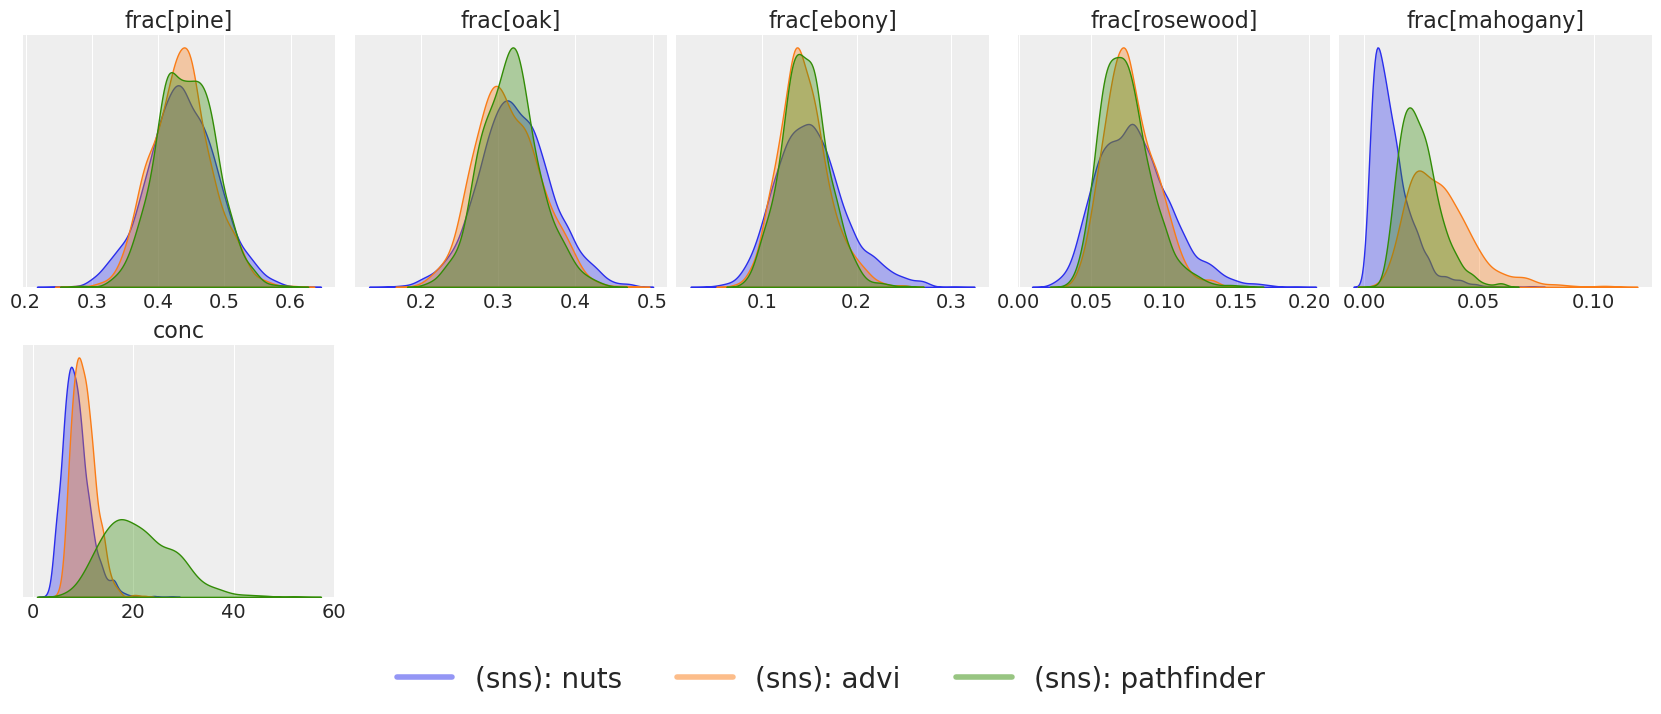

In [54]:
res = {
    "nuts": idata_nuts,
    "advi": idata_advi,
    # "pathfinder_psir": idata_psir_pf,
    "pathfinder": idata_pf,
}
plot_results(
    res,
    var_names=["frac", "conc"],
)

In [55]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,pymc

Last updated: Sun Mar 30 2025

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

pytensor: 2.28.3
pymc    : 5.21.1

matplotlib : 3.10.1
pandas     : 2.2.3
seaborn    : 0.13.2
arviz      : 0.19.0
pytensor   : 2.28.3
pymc_extras: 0.2.4
pymc       : 5.21.1
scipy      : 1.15.2
numpy      : 1.26.4
patsy      : 1.0.1

Watermark: 2.5.0

